In [1]:
import pandas as pd
import math
from unidecode import unidecode
import numpy as np
import scipy.io
from scipy.optimize import minimize
from scipy.stats import norm
import matplotlib.pyplot as plt
import os


from scipy.stats import linregress

PATH_UPV = "./DatosExperimento1/UPV"
PATH_UGR = "./DatosExperimento1/UGR"

# Leer el archivo Excel en un DataFrame de pandas
df_upv = pd.read_excel(PATH_UPV+'/Exp1_Observadores_UPV.xlsx')
df_ugr = pd.read_excel(PATH_UGR+'/Exp1_Observadores_UGR.xlsx')
    
if not os.path.exists('Resultados_UPV'):
    os.makedirs('Resultados_UPV')    

RESULTS_PATH_UPV = 'Resultados_UPV/0-PROMEDIOS'
if not os.path.exists(RESULTS_PATH_UPV):
    os.makedirs(RESULTS_PATH_UPV)

if not os.path.exists('Resultados_UGR'):
    os.makedirs('Resultados_UGR')
    
RESULTS_PATH_UGR = 'Resultados_UGR/0-PROMEDIOS'
if not os.path.exists(RESULTS_PATH_UGR):
    os.makedirs(RESULTS_PATH_UGR)
    
if not os.path.exists('Resultados_TOTAL'):
    os.makedirs('Resultados_TOTAL')
    
RESULTS_PATH_TOTAL = 'Resultados_TOTAL'

# Array de ficheros .mat, nos da igual el volunatrio
ficheros_upv = []
ficheros_ugr = []
ficheros_total = []

# Iterar sobre cada fila del DataFrame
for idx, row in df_upv.iterrows():
    ficheros_upv.append(row['Fichero'])
    ficheros_total.append(PATH_UPV+"/"+row['Fichero'])
    
for idx, row in df_ugr.iterrows():
    ficheros_ugr.append(row['Fichero'])
    ficheros_total.append(PATH_UGR+"/"+row['Fichero'])

print(ficheros_upv)
print(ficheros_ugr)
print(ficheros_total)

['ResultsJNDsNoiseFlatBG20211129T112353.mat', 'ResultsJNDsNoiseFlatBG20211129T120005.mat', 'ResultsJNDsNoiseFlatBG20211129T133717.mat', 'ResultsJNDsNoiseFlatBG20211129T140322.mat', 'ResultsJNDsNoiseFlatBG20211129T163621.mat', 'ResultsJNDsNoiseFlatBG20211129T171934.mat', 'ResultsJNDsNoiseFlatBG20211130T105700.mat', 'ResultsJNDsNoiseFlatBG20211201T114113.mat', 'ResultsJNDsNoiseFlatBG20211202T140213.mat', 'ResultsJNDsNoiseFlatBG20211202T142641.mat', 'ResultsJNDsNoiseFlatBG20211203T102719.mat', 'ResultsJNDsNoiseFlatBG20211210T101730.mat', 'ResultsJNDsNoiseFlatBG20211210T105955.mat', 'ResultsJNDsNoiseFlatBG20211210T112932.mat', 'ResultsJNDsNoiseFlatBG20211210T120626.mat', 'ResultsJNDsNoiseFlatBG20211210T145230.mat', 'ResultsJNDsNoiseFlatBG20211210T160923.mat', 'ResultsJNDsNoiseFlatBG20211210T163932.mat', 'ResultsJNDsNoiseFlatBG20211217T141916.mat', 'ResultsJNDsNoiseFlatBG20211217T171615.mat', 'ResultsJNDsNoiseFlatBG20211220T112329.mat', 'ResultsJNDsNoiseFlatBG20211222T112032.mat', 'ResultsJ

In [2]:
def normcdf2(x, mu, sigma):
    '''
    Utilizo la función norm.cdf de la librería scipy.stats para calcular la función de distribución acumulada (CDF) 
    de la distribución normal, y luego dividimos el resultado por dos y sumamos 0.5 para ajustar el rango a [0,1].
    '''
    y = (norm.cdf(x, mu, sigma) + 1) / 2
    return y

def normcdf2_minimizer(X, params):
    # X incluye mu y sigma
    mu = X[0]
    sigma = X[1]

    # x/y valores para ajustar
    x = params['x']
    y = params['y']

    # los valores ajustados con mu y sigma dados
    yfit = normcdf2(x, mu, sigma)

    # cálculo del error
    err = np.sum((yfit - y)**2)

    return err

In [3]:
# Variables generales
ruidos = scipy.io.loadmat('ruidosExp1.mat')
ruidos = np.array(ruidos['ruidos'])
minX = np.min(ruidos[:, 2])
maxX = np.max(ruidos[:, 2])
LoopNumber = 16
numberObservations = 10

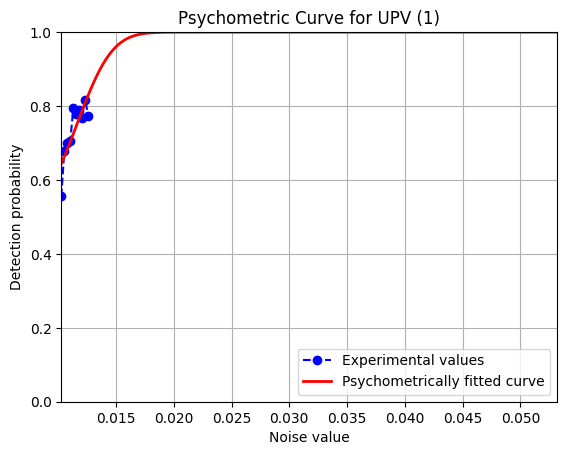

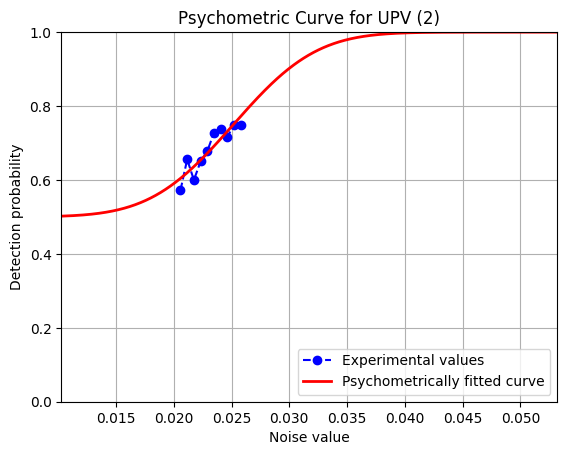

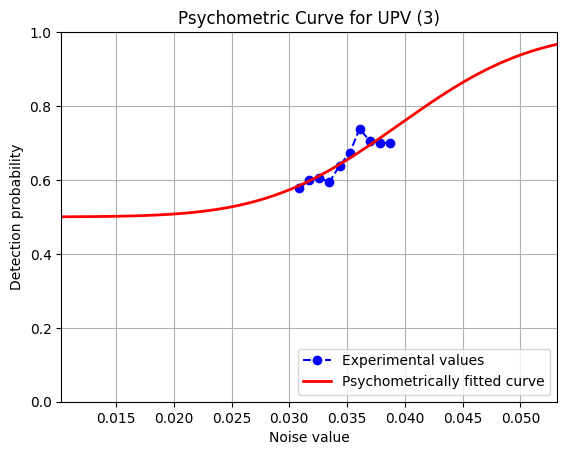

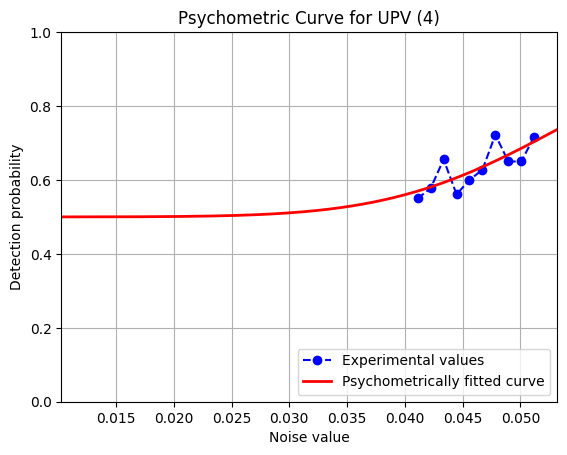

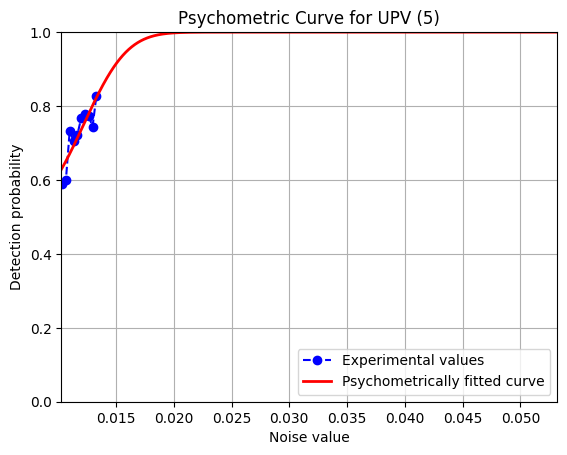

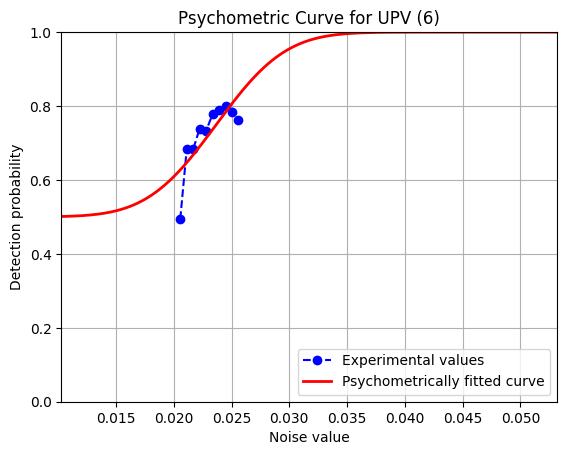

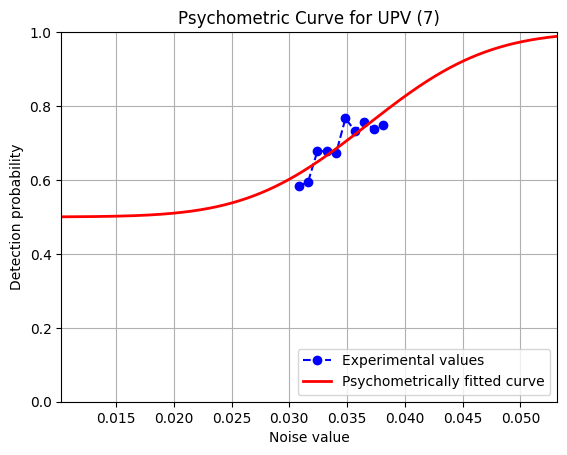

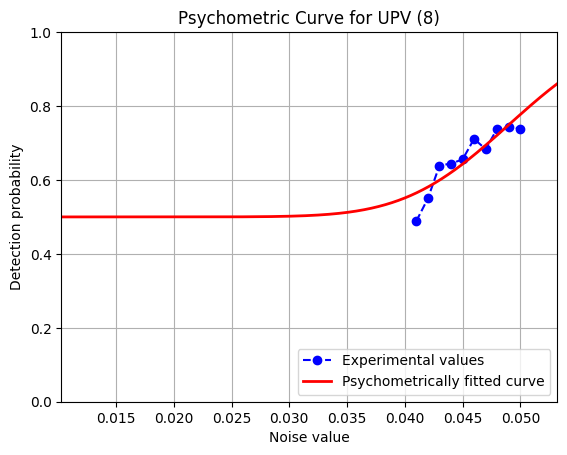

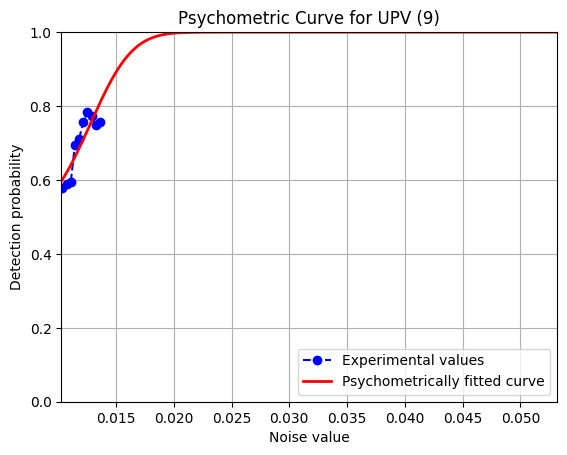

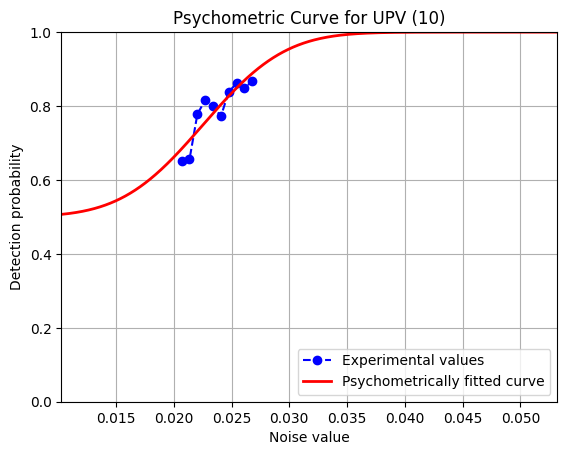

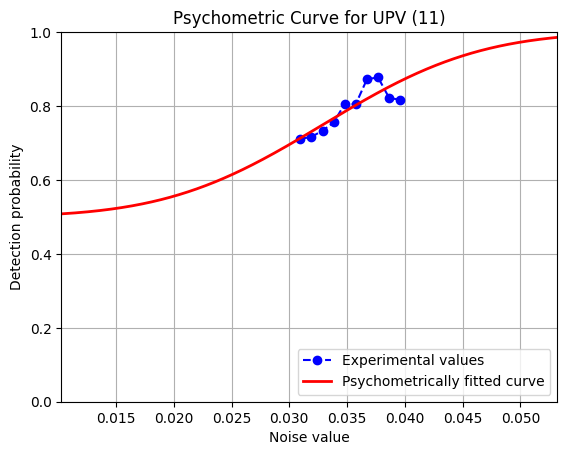

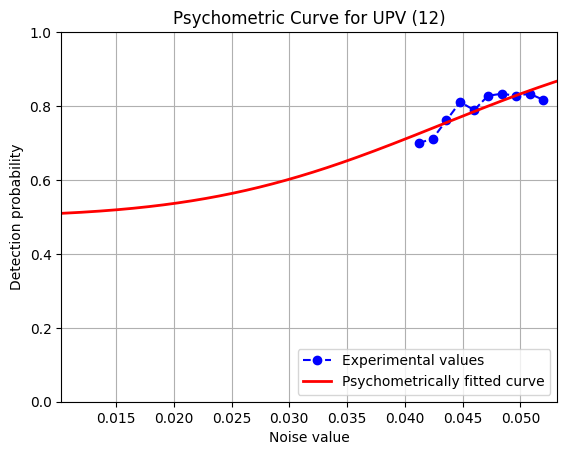

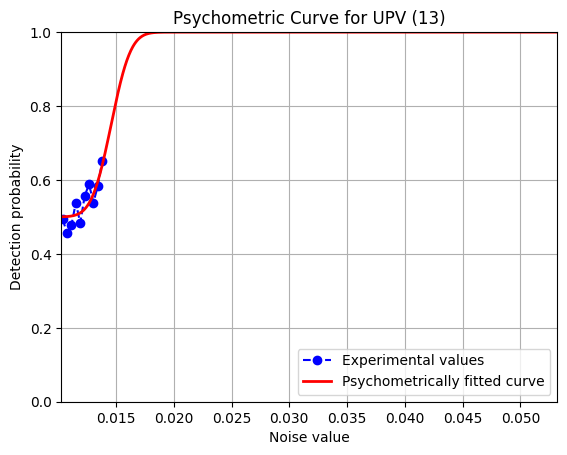

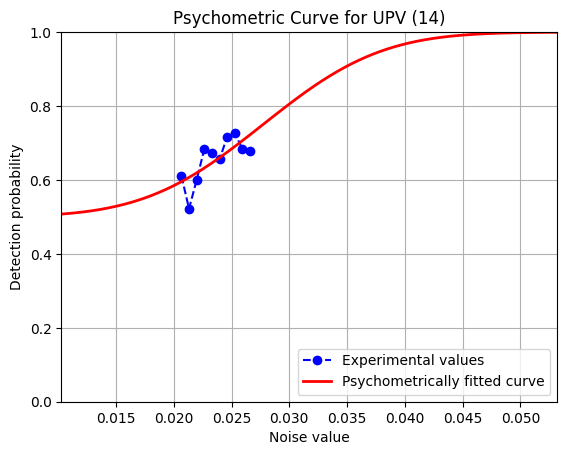

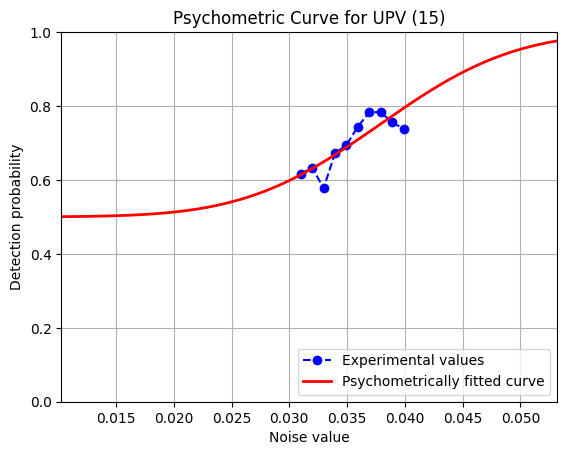

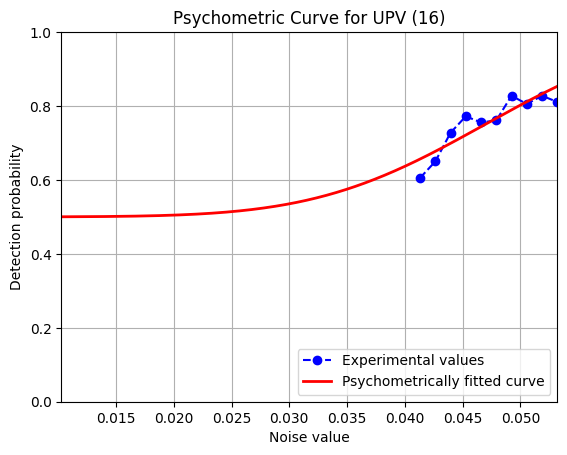

<Figure size 640x480 with 0 Axes>

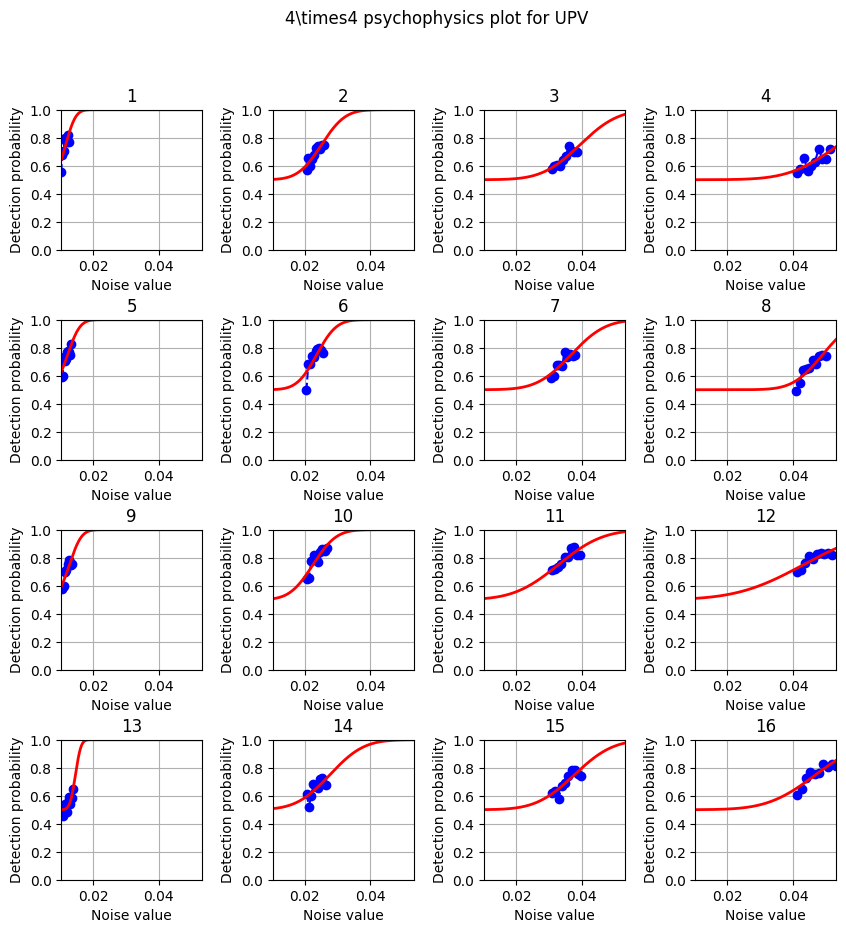

<Figure size 640x480 with 0 Axes>

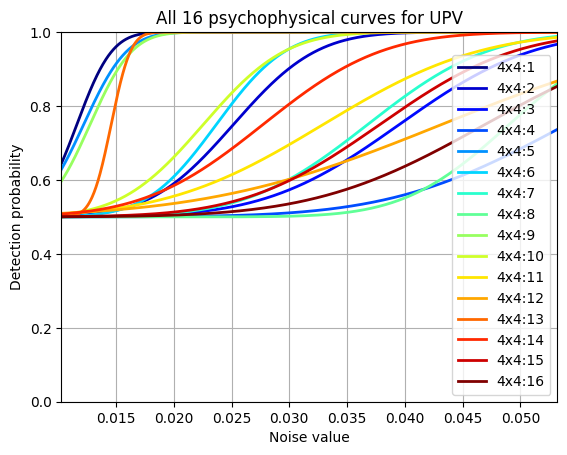

In [4]:
# UPV
mean_result_upv = None
mean_std_upv = []
for fichero in ficheros_upv:
    data_file = PATH_UPV+'/'+fichero
    result = scipy.io.loadmat(data_file)
    result = np.array(result['Results'])
    if mean_result_upv is None:
        mean_result_upv = result
    else:
        mean_result_upv = mean_result_upv + result 
        # Suma de los resultados
        # Promediar la probabilidad y Promediar el tiempo
mean_result_upv = mean_result_upv/len(ficheros_upv) # Media de los resultados para todos los ficheros de la UPV
    
# Individual plot
for i in range(LoopNumber):
    x = ruidos[i*numberObservations:(i+1)*numberObservations, 2]
    ruido_base = ruidos[i*numberObservations:(i+1)*numberObservations, 0][0]
    y = mean_result_upv[i*numberObservations:(i+1)*numberObservations, 0]

    # Valores iniciales de la minimización
    X0 = [np.mean(x), 0.1*np.mean(x)]

    # parámetros para el ajuste
    params = {'x': x, 'y': y}

    # minimización
    ParamsOpt = minimize(normcdf2_minimizer, X0, args=params, method='Nelder-Mead').x

    # media y la desviación estándar de la distribución ajustada
    # Se corresponde al umbral, ruido correspondiente a una prob de detección de 0.75
    meanAndStdDistrib = [ParamsOpt[0], ParamsOpt[1]]

    # resultados en gráficos independientes
    plt.figure(i)
    plt.plot(x, y, 'o--b')
    plt.axis([min(x), max(x), 0, 1])
    x_curve = np.linspace(minX, maxX, num=1000)
    y_curve = normcdf2(x_curve, ParamsOpt[0], ParamsOpt[1])
    plt.plot(x_curve, y_curve, '-r', linewidth=2)
    plt.title('Psychometric Curve for UPV ('+ str(i+1)+")")
    plt.xlabel('Noise value')
    plt.ylabel('Detection probability')
    plt.legend(['Experimental values', 'Psychometrically fitted curve'], loc='lower right')
    plt.grid(True)
    plt.xlim([minX, maxX])
    plt.ylim([0, 1])

    # Guardar el gráfico y los datos en .npy
    plt.savefig(RESULTS_PATH_UPV+'/UPV-plot-' + str(i+1) + '.png')
    np.save(RESULTS_PATH_UPV+'/UPV-MeanStdDistribution-' + str(i+1) + '.npy', meanAndStdDistrib)
    
    plt.show()
    mean_std_upv.append((ruido_base, round(ParamsOpt[0], 6), round(ParamsOpt[1], 6)))


# 4 times 4 psychophysics plot

plt.figure() 
figure = plt.figure(figsize=(numberObservations, numberObservations))
figure.subplots_adjust(hspace=0.5, wspace=0.5)

for i in range(LoopNumber):
    x = ruidos[i*numberObservations:(i+1)*numberObservations, 2]
    y = mean_result_upv[i*numberObservations:(i+1)*numberObservations, 0]

    # Valores iniciales de la minimización
    X0 = [np.mean(x), 0.1*np.mean(x)]

    # Definir los parámetros para el ajuste
    params = {'x': x, 'y': y}

    # Realizar la minimización
    ParamsOpt = minimize(normcdf2_minimizer, X0, args=params, method='Nelder-Mead').x

    # Obtener la media y la desviación estándar de la distribución ajustada
    meanAndStdDistrib = [ParamsOpt[0], ParamsOpt[1]]

    ax = figure.add_subplot(4, 4, i+1)
    ax.plot(x, y, 'o--b')
    x_curve = np.linspace(minX, maxX, num=1000)
    y_curve = normcdf2(x_curve, ParamsOpt[0], ParamsOpt[1])
    ax.plot(x_curve, y_curve, '-r', linewidth=2)
    ax.grid(True)
    ax.set_xlim([minX, maxX])
    ax.set_ylim([0, 1])
    ax.set_title(str(i+1))
    ax.set_xlabel('Noise value')
    ax.set_ylabel('Detection probability')

figure.suptitle('4\\times4 psychophysics plot for UPV')
plt.savefig(RESULTS_PATH_UPV+'/UPV-MosaicWithEqualXAxes-' + str(i+1) + '.png')


# All 16 psychophysical curves

plt.figure() 
cc = plt.get_cmap('jet')(np.linspace(0, 1, 16))

fig, ax = plt.subplots()
for i in range(LoopNumber):
    x = ruidos[i*numberObservations:(i+1)*numberObservations, 2]
    y = mean_result_upv[i*numberObservations:(i+1)*numberObservations, 0]

    # Valores iniciales de la minimización
    X0 = [np.mean(x), 0.1*np.mean(x)]

    # Definir los parámetros para el ajuste
    params = {'x': x, 'y': y}

    # Realizar la minimización
    ParamsOpt = minimize(normcdf2_minimizer, X0, args=params, method='Nelder-Mead').x

    # Obtener la media y la desviación estándar de la distribución ajustada
    meanAndStdDistrib = [ParamsOpt[0], ParamsOpt[1]]

    x_curve = np.linspace(minX, maxX, num=1000)
    y_curve = normcdf2(x_curve, ParamsOpt[0], ParamsOpt[1])
    ax.plot(x_curve, y_curve, linewidth=2, color=cc[i])
    ax.grid(True)
    ax.set_xlim([minX, maxX])
    ax.set_ylim([0, 1])
    ax.set_xlabel('Noise value')
    ax.set_ylabel('Detection probability')

ax.set_title('All 16 psychophysical curves for UPV')

Legend = []
for i in range(16):
    Legend.append('4x4:{}'.format(i+1))

ax.legend(Legend)

plt.savefig(RESULTS_PATH_UPV+'/UPV-AllPsychomPlots-' + str(i+1) + '.png')

In [5]:
data_upv = [row for row in [mean_std_upv[i:i+4] for i in range(0, 16, 4)]]
for row in data_upv:
    print(row)
mean_std_upv

[(0.01, 0.011607, 0.002403), (0.02, 0.025164, 0.005649), (0.03, 0.039522, 0.009064), (0.04, 0.053994, 0.011909)]
[(0.01, 0.012196, 0.00296), (0.02, 0.02368, 0.004724), (0.03, 0.036786, 0.008197), (0.04, 0.049028, 0.007125)]
[(0.01, 0.012747, 0.002871), (0.02, 0.022552, 0.005572), (0.03, 0.032933, 0.01064), (0.04, 0.043185, 0.015927)]
[(0.01, 0.014579, 0.001328), (0.02, 0.027725, 0.008075), (0.03, 0.037835, 0.009188), (0.04, 0.046935, 0.011525)]


[(0.01, 0.011607, 0.002403),
 (0.02, 0.025164, 0.005649),
 (0.03, 0.039522, 0.009064),
 (0.04, 0.053994, 0.011909),
 (0.01, 0.012196, 0.00296),
 (0.02, 0.02368, 0.004724),
 (0.03, 0.036786, 0.008197),
 (0.04, 0.049028, 0.007125),
 (0.01, 0.012747, 0.002871),
 (0.02, 0.022552, 0.005572),
 (0.03, 0.032933, 0.01064),
 (0.04, 0.043185, 0.015927),
 (0.01, 0.014579, 0.001328),
 (0.02, 0.027725, 0.008075),
 (0.03, 0.037835, 0.009188),
 (0.04, 0.046935, 0.011525)]

Nivel de Luminancia: 0
Coeficiente de correlación (r): 0.9998837285733617


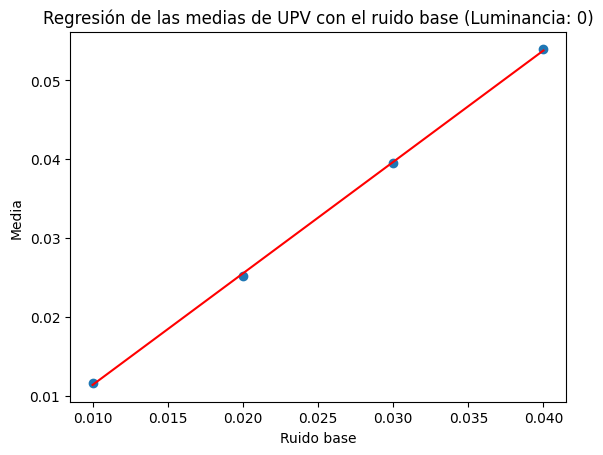

Nivel de Luminancia: 1
Coeficiente de correlación (r): 0.9997038448188796


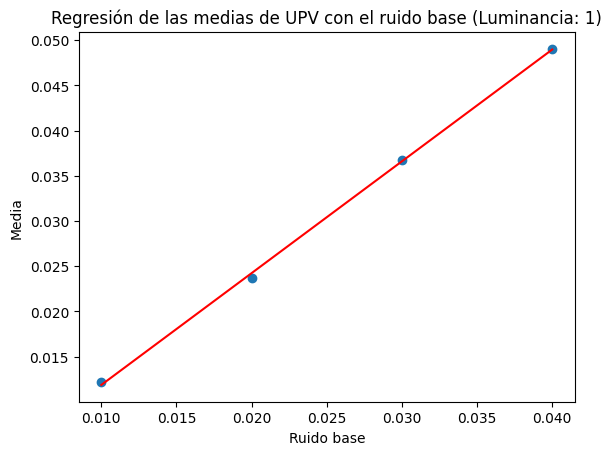

Nivel de Luminancia: 2
Coeficiente de correlación (r): 0.9999276771384522


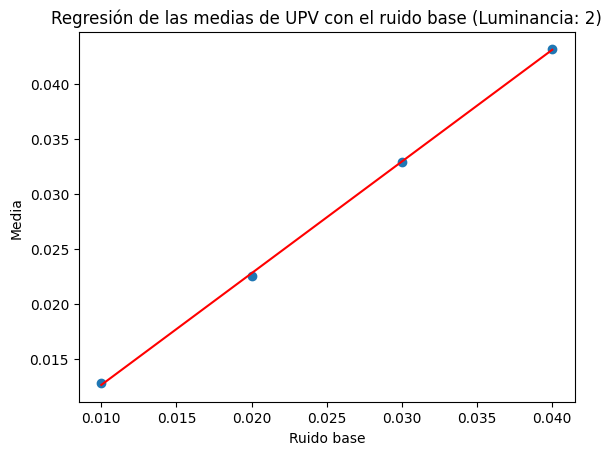

Nivel de Luminancia: 3
Coeficiente de correlación (r): 0.9962794925603862


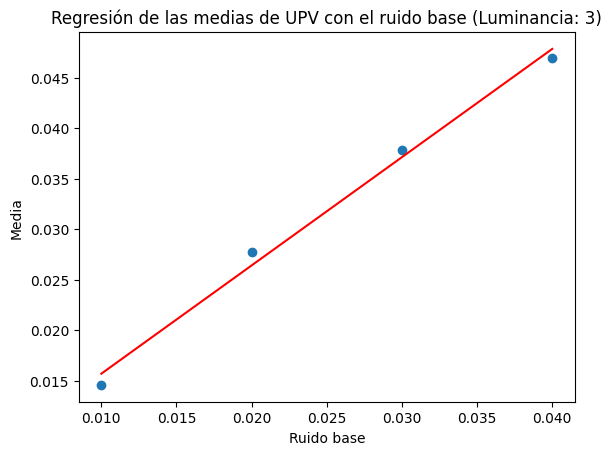

In [6]:
# Regresión de las medias y el ruido base
medias = np.array([i[1] for row in data_upv for i in row])
ruido_base = np.array([i[0] for row in data_upv for i in row])
luminancias = np.array([0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3])

# Realizar regresión por cada nivel de luminancia
unique_luminancias = np.unique(luminancias)
for luminancia in unique_luminancias:
    # Filtrar datos correspondientes a la luminancia actual
    luminancia_indices = np.where(luminancias == luminancia)
    luminancia_ruido_base = ruido_base[luminancia_indices]
    luminancia_medias = medias[luminancia_indices]

    # Realizar regresión lineal
    slope, intercept, r_value, p_value, std_err = linregress(luminancia_ruido_base, luminancia_medias)
    print("Nivel de Luminancia:", luminancia)
    print("Coeficiente de correlación (r):", r_value)

    # Graficar los resultados
    plt.scatter(luminancia_ruido_base, luminancia_medias)
    plt.plot(luminancia_ruido_base, intercept + slope * luminancia_ruido_base, 'r')
    plt.title('Regresión de las medias de UPV con el ruido base (Luminancia: {})'.format(luminancia))
    plt.xlabel('Ruido base')
    plt.ylabel('Media')
    plt.show()

Coeficiente de correlación (r): 0.6288400878198365


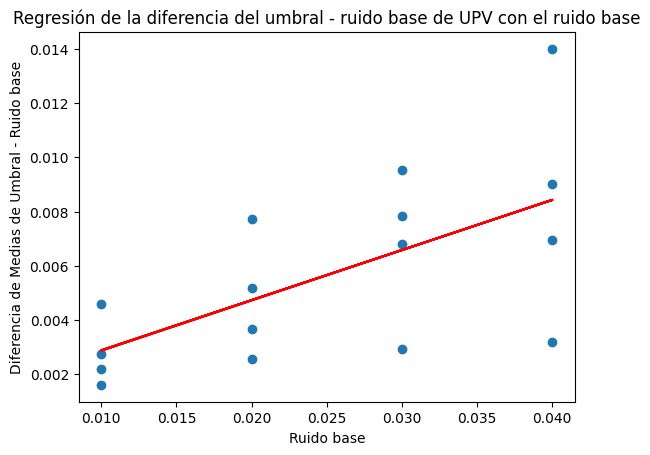

Coeficiente de correlación (r): -0.1692226914164471


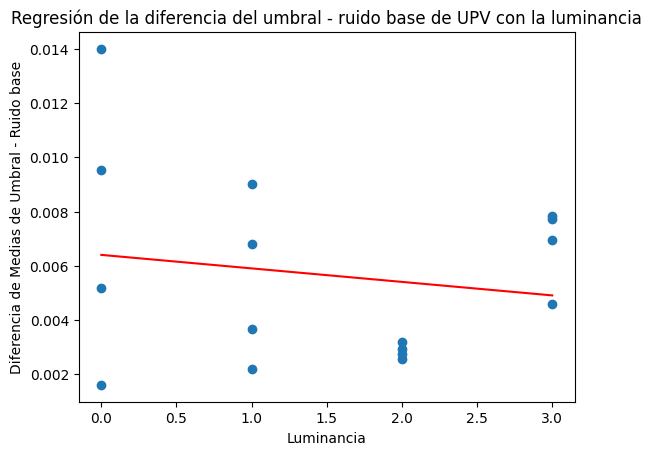

In [6]:
# Regresión de la diferencia del umbral - ruido base y el ruido base

dif_u_r = np.array([i[1]-i[0] for row in data_upv for i in row])
ruido_base = np.array([i[0] for row in data_upv for i in row])
luminancias = np.array([0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3])

slope, intercept, r_value, p_value, std_err = linregress(ruido_base, dif_u_r)
print("Coeficiente de correlación (r):", r_value)

plt.scatter(ruido_base, dif_u_r)
plt.plot(ruido_base, intercept + slope * ruido_base, 'r')
plt.title('Regresión de la diferencia del umbral - ruido base de UPV con el ruido base')
plt.xlabel('Ruido base')
plt.ylabel('Diferencia de Medias de Umbral - Ruido base')
plt.show()

slope, intercept, r_value, p_value, std_err = linregress(luminancias, dif_u_r)
print("Coeficiente de correlación (r):", r_value)

plt.scatter(luminancias, dif_u_r)
plt.plot(luminancias, intercept + slope * luminancias, 'r')
plt.title('Regresión de la diferencia del umbral - ruido base de UPV con la luminancia')
plt.xlabel('Luminancia')
plt.ylabel('Diferencia de Medias de Umbral - Ruido base')
plt.show()

[0.1607     0.2582     0.3174     0.34985    0.2196     0.184
 0.2262     0.2257     0.2747     0.1276     0.09776667 0.079625
 0.4579     0.38625    0.26116667 0.173375  ]
Coeficiente de correlación (r): -0.2517700955837889


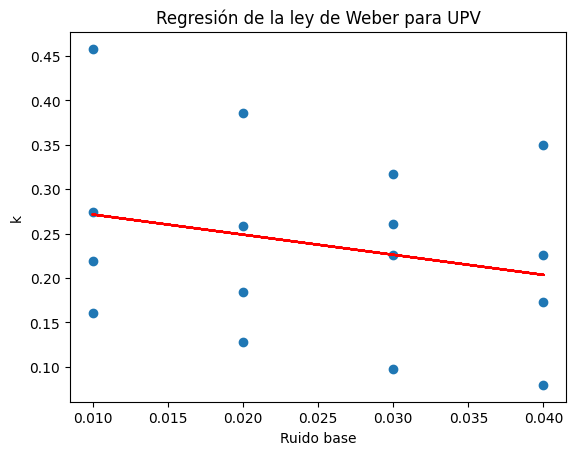

In [8]:
# Ley de Weber UPV

# La diferencia mínima perceptible entre el ruido base y el ruido umbral en cada es cociente %
# (u-r)/r = k
k = np.array([((i[1]-i[0])/i[0]) for row in data_upv for i in row])
print(k)
slope, intercept, r_value, p_value, std_err = linregress(ruido_base, k)
print("Coeficiente de correlación (r):", r_value)

plt.scatter(ruido_base, k)
plt.plot(ruido_base, intercept + slope * ruido_base, 'r')
plt.title('Regresión de la ley de Weber para UPV')
plt.xlabel('Ruido base')
plt.ylabel('k')
plt.show()

Coeficiente de correlación (r): 0.8878041461756107


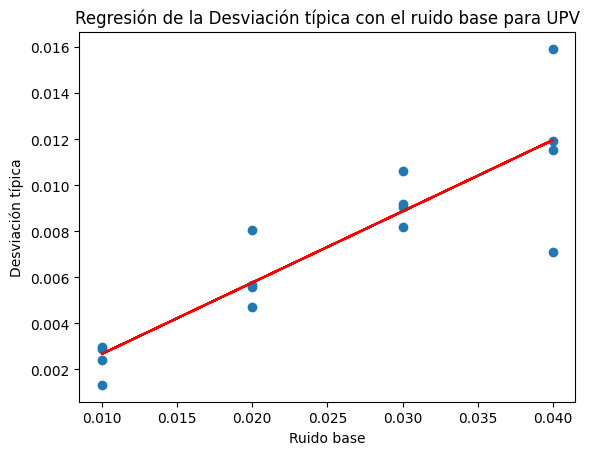

Coeficiente de correlación (r): 0.10951933480127593


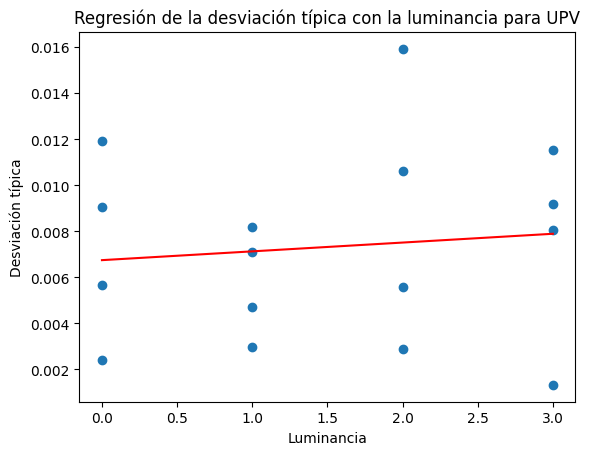

In [9]:
# Regresión de la desviación típica y el ruido base

std = np.array([i[2] for row in data_upv for i in row])
ruido_base = np.array([i[0] for row in data_upv for i in row])
luminancias = np.array([0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3])

slope, intercept, r_value, p_value, std_err = linregress(ruido_base, std)
print("Coeficiente de correlación (r):", r_value)

plt.scatter(ruido_base, std)
plt.plot(ruido_base, intercept + slope * ruido_base, 'r')
plt.title('Regresión de la Desviación típica con el ruido base para UPV')
plt.xlabel('Ruido base')
plt.ylabel('Desviación típica')
plt.show()

# Regresión de la desviación típica y la luminancia

slope, intercept, r_value, p_value, std_err = linregress(luminancias, std)
print("Coeficiente de correlación (r):", r_value)

plt.scatter(luminancias, std)
plt.plot(luminancias, intercept + slope * luminancias, 'r')
plt.title('Regresión de la desviación típica con la luminancia para UPV')
plt.xlabel('Luminancia')
plt.ylabel('Desviación típica')
plt.show()

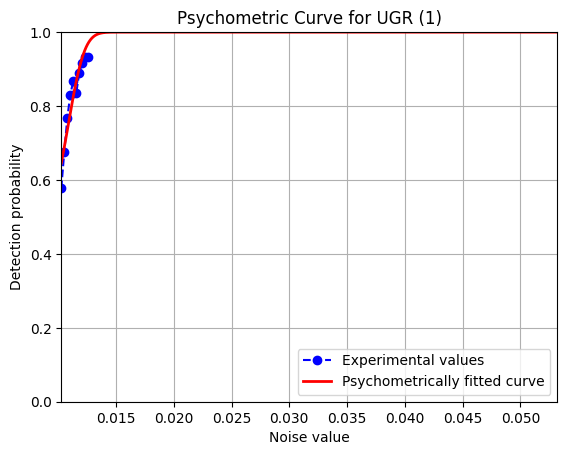

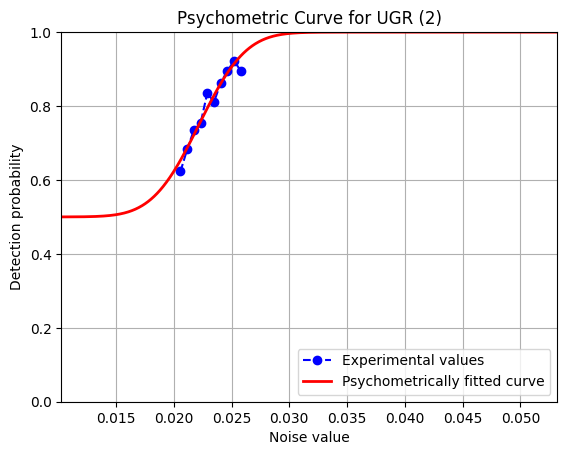

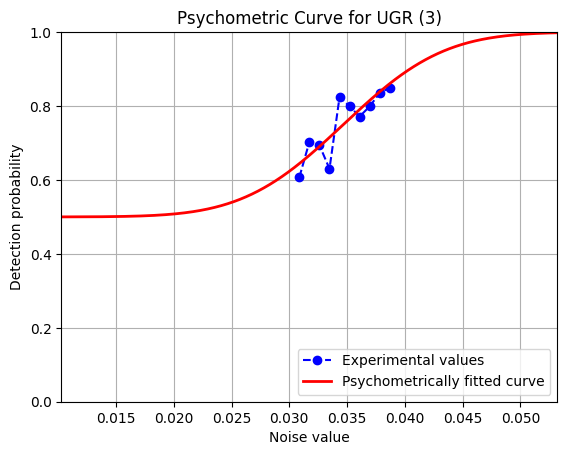

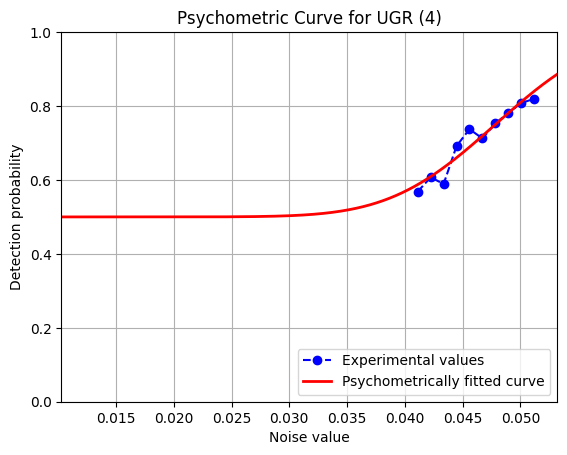

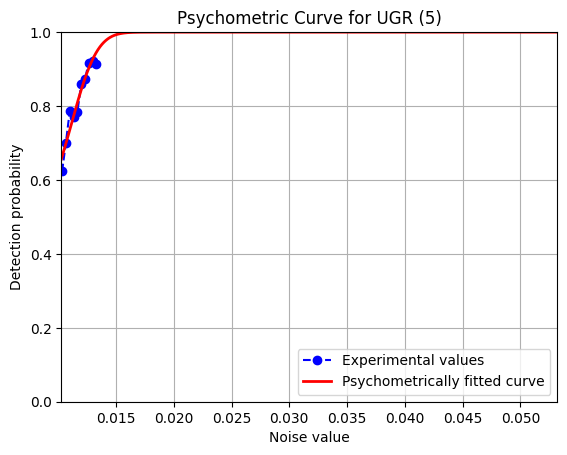

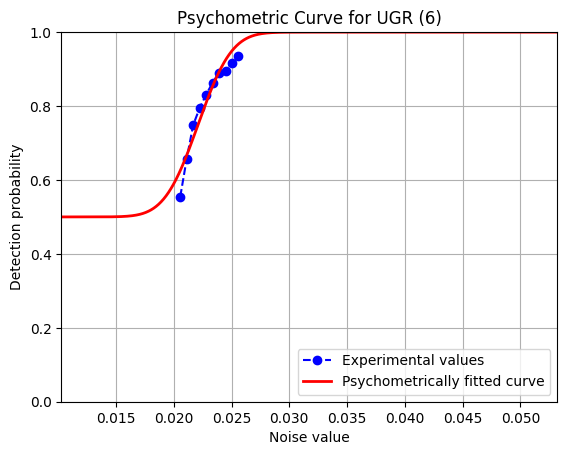

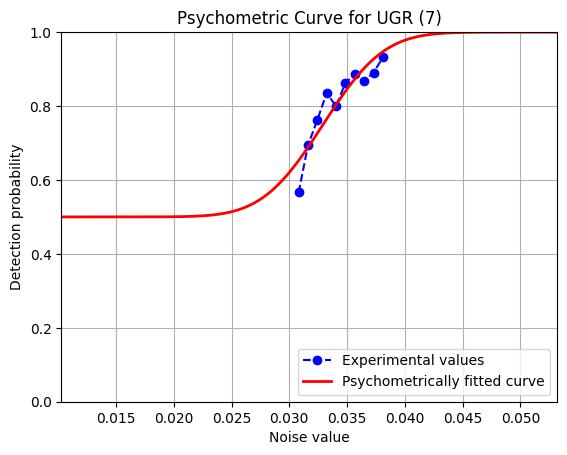

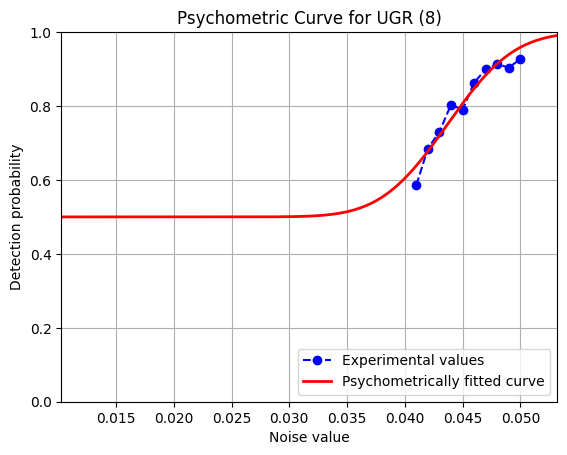

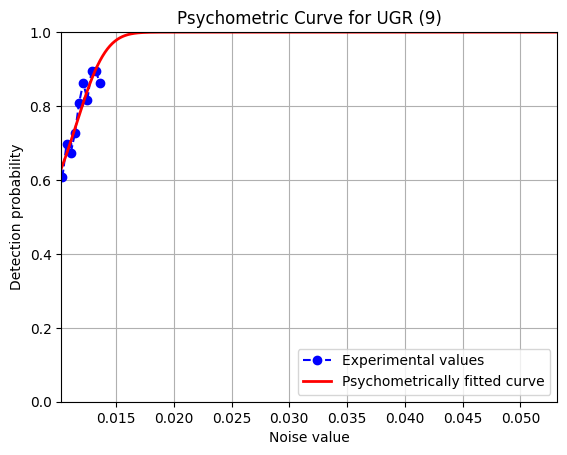

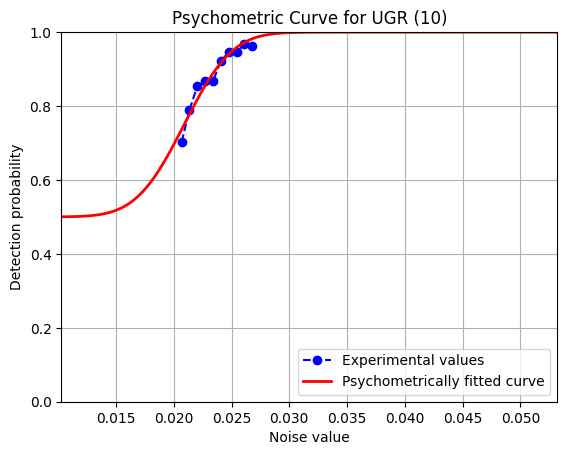

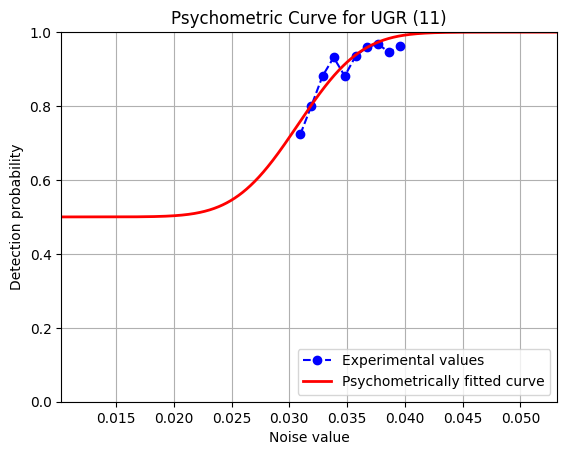

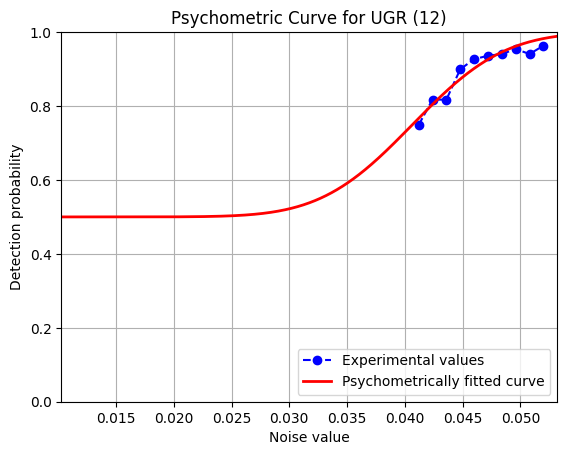

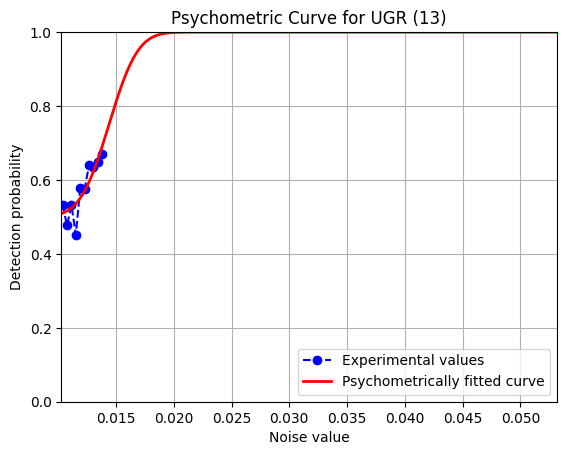

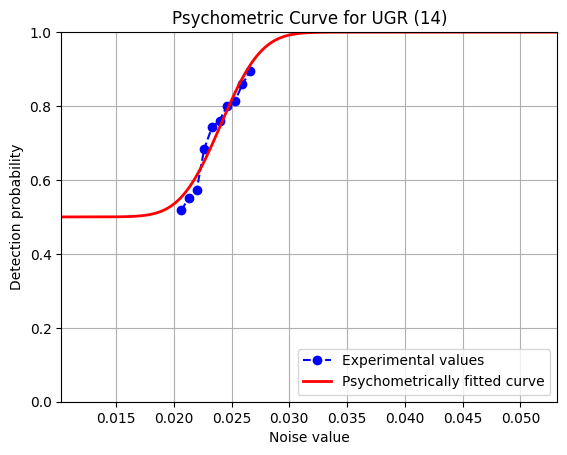

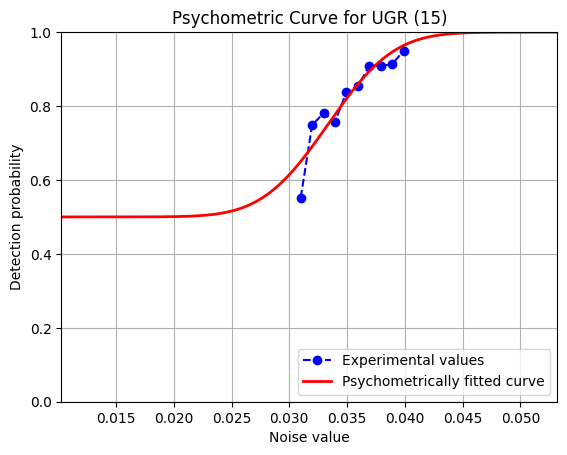

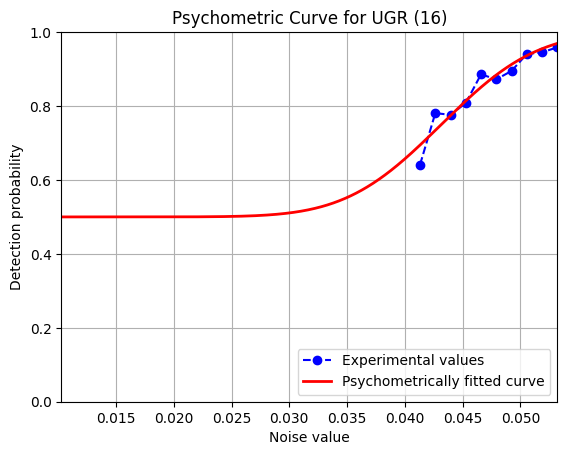

<Figure size 640x480 with 0 Axes>

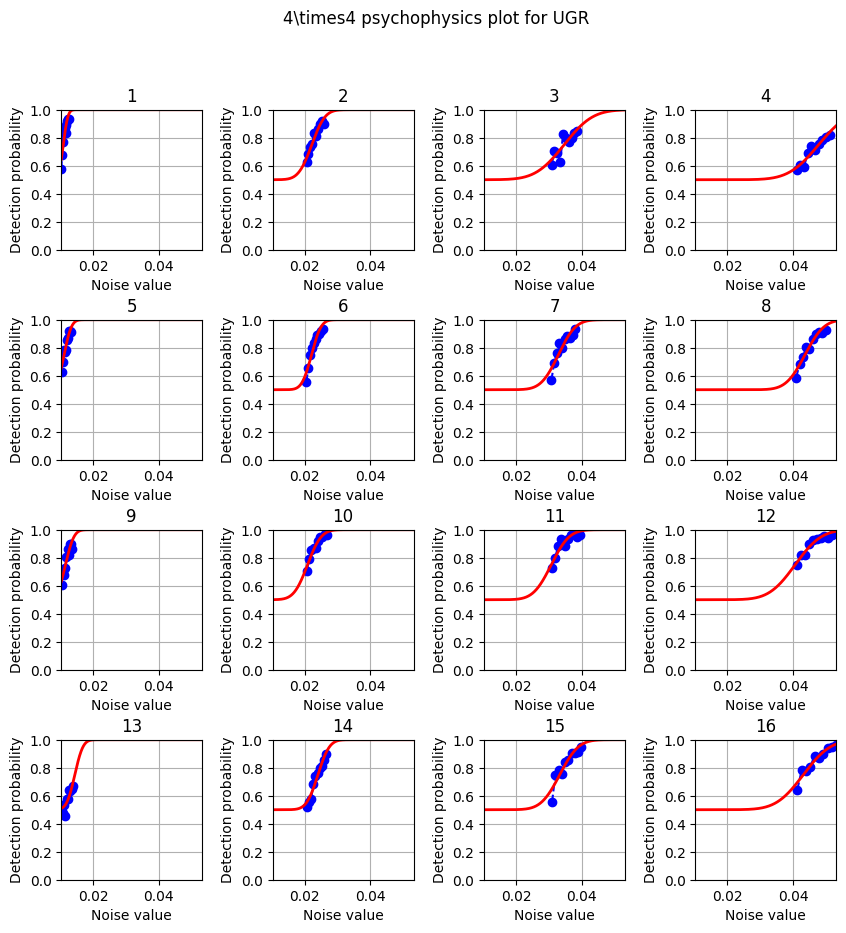

<Figure size 640x480 with 0 Axes>

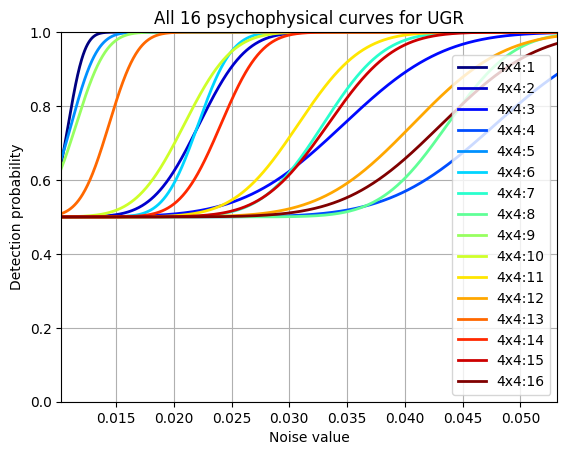

In [10]:
# UGR
mean_result_ugr = None
mean_std_ugr = []
for fichero in ficheros_ugr:
    data_file = PATH_UGR+'/'+fichero
    result = scipy.io.loadmat(data_file)
    result = np.array(result['Results'])
    if mean_result_ugr is None:
        mean_result_ugr = result
    else:
        mean_result_ugr = mean_result_ugr + result 
        # Suma de los resultados
        # Promediar la probabilidad y Promediar el tiempo
mean_result_ugr = mean_result_ugr/len(ficheros_ugr) # Media de los resultados para todos los ficheros de la UGR
    
# Individual plot
for i in range(LoopNumber):
    x = ruidos[i*numberObservations:(i+1)*numberObservations, 2]
    ruido_base = ruidos[i*numberObservations:(i+1)*numberObservations, 0][0]
    y = mean_result_ugr[i*numberObservations:(i+1)*numberObservations, 0]

    # Valores iniciales de la minimización
    X0 = [np.mean(x), 0.1*np.mean(x)]

    # parámetros para el ajuste
    params = {'x': x, 'y': y}

    # minimización
    ParamsOpt = minimize(normcdf2_minimizer, X0, args=params, method='Nelder-Mead').x

    # media y la desviación estándar de la distribución ajustada
    meanAndStdDistrib = [ParamsOpt[0], ParamsOpt[1]]

    # resultados en gráficos independientes
    plt.figure(i)
    plt.plot(x, y, 'o--b')
    plt.axis([min(x), max(x), 0, 1])
    x_curve = np.linspace(minX, maxX, num=1000)
    y_curve = normcdf2(x_curve, ParamsOpt[0], ParamsOpt[1])
    plt.plot(x_curve, y_curve, '-r', linewidth=2)
    plt.title('Psychometric Curve for UGR ('+ str(i+1)+")")
    plt.xlabel('Noise value')
    plt.ylabel('Detection probability')
    plt.legend(['Experimental values', 'Psychometrically fitted curve'], loc='lower right')
    plt.grid(True)
    plt.xlim([minX, maxX])
    plt.ylim([0, 1])

    # Guardar el gráfico y los datos en .npy
    plt.savefig(RESULTS_PATH_UGR+'/UGR-plot-' + str(i+1) + '.png')
    np.save(RESULTS_PATH_UGR+'/UGR-MeanStdDistribution-' + str(i+1) + '.npy', meanAndStdDistrib)
    mean_std_ugr.append((ruido_base, round(ParamsOpt[0], 6), round(ParamsOpt[1], 6)))

    plt.show()


# 4 times 4 psychophysics plot

plt.figure() 
figure = plt.figure(figsize=(numberObservations, numberObservations))
figure.subplots_adjust(hspace=0.5, wspace=0.5)

for i in range(LoopNumber):
    x = ruidos[i*numberObservations:(i+1)*numberObservations, 2]
    y = mean_result_ugr[i*numberObservations:(i+1)*numberObservations, 0]

    # Valores iniciales de la minimización
    X0 = [np.mean(x), 0.1*np.mean(x)]

    # Definir los parámetros para el ajuste
    params = {'x': x, 'y': y}

    # Realizar la minimización
    ParamsOpt = minimize(normcdf2_minimizer, X0, args=params, method='Nelder-Mead').x

    # Obtener la media y la desviación estándar de la distribución ajustada
    meanAndStdDistrib = [ParamsOpt[0], ParamsOpt[1]]

    ax = figure.add_subplot(4, 4, i+1)
    ax.plot(x, y, 'o--b')
    x_curve = np.linspace(minX, maxX, num=1000)
    y_curve = normcdf2(x_curve, ParamsOpt[0], ParamsOpt[1])
    ax.plot(x_curve, y_curve, '-r', linewidth=2)
    ax.grid(True)
    ax.set_xlim([minX, maxX])
    ax.set_ylim([0, 1])
    ax.set_title(str(i+1))
    ax.set_xlabel('Noise value')
    ax.set_ylabel('Detection probability')

figure.suptitle('4\\times4 psychophysics plot for UGR')
plt.savefig(RESULTS_PATH_UGR+'/UGR-MosaicWithEqualXAxes-' + str(i+1) + '.png')

# All 16 psychophysical curves

plt.figure() 
cc = plt.get_cmap('jet')(np.linspace(0, 1, 16))

fig, ax = plt.subplots()
for i in range(LoopNumber):
    x = ruidos[i*numberObservations:(i+1)*numberObservations, 2]
    y = mean_result_ugr[i*numberObservations:(i+1)*numberObservations, 0]

    # Valores iniciales de la minimización
    X0 = [np.mean(x), 0.1*np.mean(x)]

    # Definir los parámetros para el ajuste
    params = {'x': x, 'y': y}

    # Realizar la minimización
    ParamsOpt = minimize(normcdf2_minimizer, X0, args=params, method='Nelder-Mead').x

    # Obtener la media y la desviación estándar de la distribución ajustada
    meanAndStdDistrib = [ParamsOpt[0], ParamsOpt[1]]

    x_curve = np.linspace(minX, maxX, num=1000)
    y_curve = normcdf2(x_curve, ParamsOpt[0], ParamsOpt[1])
    ax.plot(x_curve, y_curve, linewidth=2, color=cc[i])
    ax.grid(True)
    ax.set_xlim([minX, maxX])
    ax.set_ylim([0, 1])
    ax.set_xlabel('Noise value')
    ax.set_ylabel('Detection probability')

ax.set_title('All 16 psychophysical curves for UGR')

Legend = []
for i in range(16):
    Legend.append('4x4:{}'.format(i+1))

ax.legend(Legend)

plt.savefig(RESULTS_PATH_UGR+'/UGR-AllPsychomPlots-' + str(i+1) + '.png')
print()

In [11]:
data_ugr = [row for row in [mean_std_ugr[i:i+4] for i in range(0, 16, 4)]]
for row in data_ugr:
    print(row)
mean_std_ugr

[(0.01, 0.010867, 0.001107), (0.02, 0.022187, 0.003187), (0.03, 0.034682, 0.006838), (0.04, 0.047834, 0.007186)]
[(0.01, 0.011123, 0.001766), (0.02, 0.022106, 0.002299), (0.03, 0.032921, 0.004147), (0.04, 0.043683, 0.004548)]
[(0.01, 0.011551, 0.002026), (0.02, 0.020899, 0.003275), (0.03, 0.030758, 0.004312), (0.04, 0.040668, 0.006249)]
[(0.01, 0.01439, 0.00196), (0.02, 0.024073, 0.002754), (0.03, 0.03334, 0.004492), (0.04, 0.043154, 0.006503)]


[(0.01, 0.010867, 0.001107),
 (0.02, 0.022187, 0.003187),
 (0.03, 0.034682, 0.006838),
 (0.04, 0.047834, 0.007186),
 (0.01, 0.011123, 0.001766),
 (0.02, 0.022106, 0.002299),
 (0.03, 0.032921, 0.004147),
 (0.04, 0.043683, 0.004548),
 (0.01, 0.011551, 0.002026),
 (0.02, 0.020899, 0.003275),
 (0.03, 0.030758, 0.004312),
 (0.04, 0.040668, 0.006249),
 (0.01, 0.01439, 0.00196),
 (0.02, 0.024073, 0.002754),
 (0.03, 0.03334, 0.004492),
 (0.04, 0.043154, 0.006503)]

Coeficiente de correlación (r): 0.989538155015744


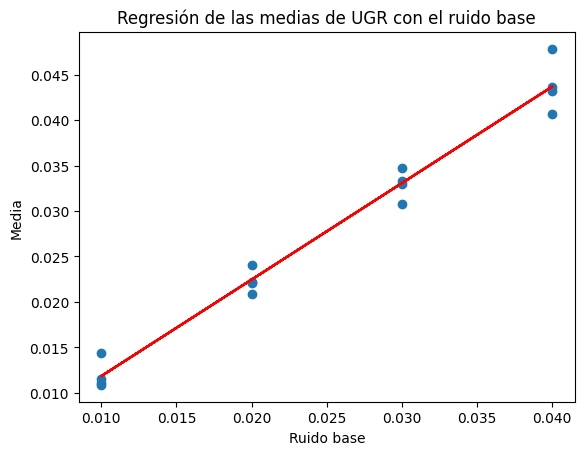

Coeficiente de correlación (r): -0.01816615517473441


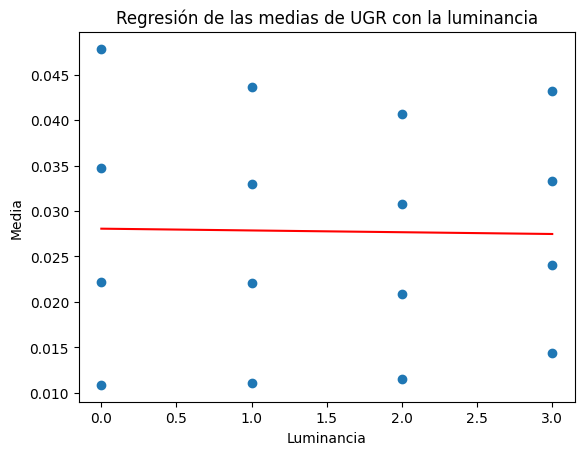

In [12]:
# Regresión de las medias y el ruido base

medias = np.array([i[1] for row in data_ugr for i in row])
ruido_base = np.array([i[0] for row in data_ugr for i in row])
luminancias = np.array([0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3])

slope, intercept, r_value, p_value, std_err = linregress(ruido_base, medias)
print("Coeficiente de correlación (r):", r_value)

plt.scatter(ruido_base, medias)
plt.plot(ruido_base, intercept + slope * ruido_base, 'r')
plt.title('Regresión de las medias de UGR con el ruido base')
plt.xlabel('Ruido base')
plt.ylabel('Media')
plt.show()

slope, intercept, r_value, p_value, std_err = linregress(luminancias, medias)
print("Coeficiente de correlación (r):", r_value)

plt.scatter(luminancias, medias)
plt.plot(luminancias, intercept + slope * luminancias, 'r')
plt.title('Regresión de las medias de UGR con la luminancia')
plt.xlabel('Luminancia')
plt.ylabel('Media')
plt.show()


Coeficiente de correlación (r): 0.37002413320637406


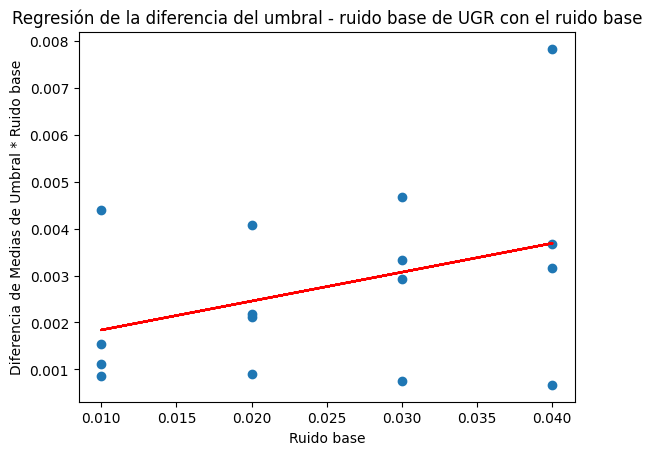

Coeficiente de correlación (r): -0.11697924340944392


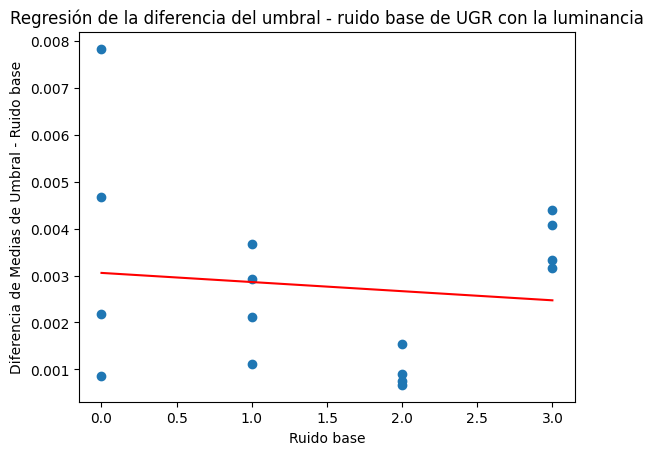

In [13]:
# Regresión de la diferencia del umbral - ruido base y el ruido base

dif_u_r = np.array([i[1]-i[0] for row in data_ugr for i in row])
ruido_base = np.array([i[0] for row in data_ugr for i in row])
luminancias = np.array([0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3])

slope, intercept, r_value, p_value, std_err = linregress(ruido_base, dif_u_r)
print("Coeficiente de correlación (r):", r_value)

plt.scatter(ruido_base, dif_u_r)
plt.plot(ruido_base, intercept + slope * ruido_base, 'r')
plt.title('Regresión de la diferencia del umbral - ruido base de UGR con el ruido base')
plt.xlabel('Ruido base')
plt.ylabel('Diferencia de Medias de Umbral * Ruido base')
plt.show()

slope, intercept, r_value, p_value, std_err = linregress(luminancias, dif_u_r)
print("Coeficiente de correlación (r):", r_value)

plt.scatter(luminancias, dif_u_r)
plt.plot(luminancias, intercept + slope * luminancias, 'r')
plt.title('Regresión de la diferencia del umbral - ruido base de UGR con la luminancia')
plt.xlabel('Ruido base')
plt.ylabel('Diferencia de Medias de Umbral - Ruido base')
plt.show()

[0.0867     0.10935    0.15606667 0.19585    0.1123     0.1053
 0.09736667 0.092075   0.1551     0.04495    0.02526667 0.0167
 0.439      0.20365    0.11133333 0.07885   ]
Coeficiente de correlación (r): -0.38083139161207946


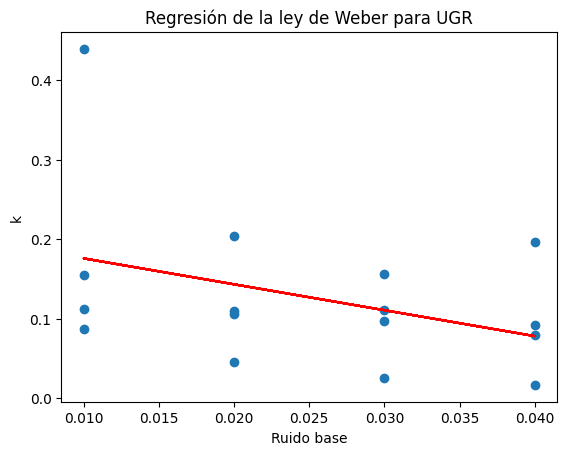

In [14]:
# Ley de Weber UGR

# La diferencia mínima perceptible entre el ruido base y el ruido umbral en cada es cociente %
# (u-r)/r = k
k = np.array([((i[1]-i[0])/i[0]) for row in data_ugr for i in row])
print(k)
slope, intercept, r_value, p_value, std_err = linregress(ruido_base, k)
print("Coeficiente de correlación (r):", r_value)

plt.scatter(ruido_base, k)
plt.plot(ruido_base, intercept + slope * ruido_base, 'r')
plt.title('Regresión de la ley de Weber para UGR')
plt.xlabel('Ruido base')
plt.ylabel('k')
plt.show()

Coeficiente de correlación (r): 0.9046273940505664


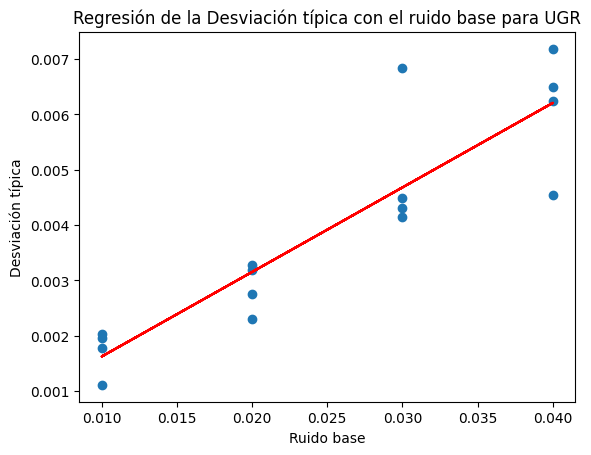

Coeficiente de correlación (r): -0.06989394876770379


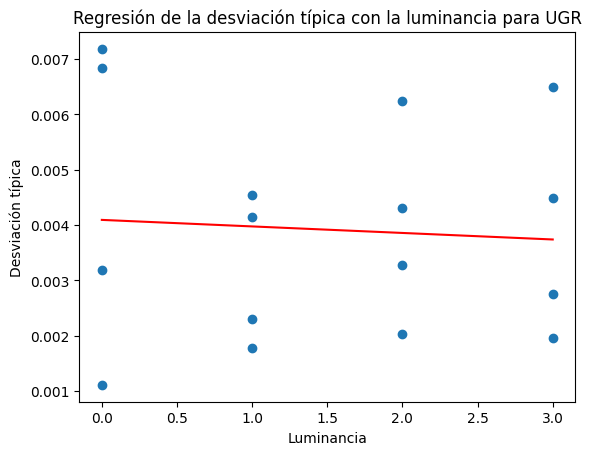

In [15]:
# Regresión de la desviación típica y el ruido base

std = np.array([i[2] for row in data_ugr for i in row])
ruido_base = np.array([i[0] for row in data_ugr for i in row])
luminancias = np.array([0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3])

slope, intercept, r_value, p_value, std_err = linregress(ruido_base, std)
print("Coeficiente de correlación (r):", r_value)

plt.scatter(ruido_base, std)
plt.plot(ruido_base, intercept + slope * ruido_base, 'r')
plt.title('Regresión de la Desviación típica con el ruido base para UGR')
plt.xlabel('Ruido base')
plt.ylabel('Desviación típica')
plt.show()

# Regresión de la desviación típica y la luminancia

slope, intercept, r_value, p_value, std_err = linregress(luminancias, std)
print("Coeficiente de correlación (r):", r_value)

plt.scatter(luminancias, std)
plt.plot(luminancias, intercept + slope * luminancias, 'r')
plt.title('Regresión de la desviación típica con la luminancia para UGR')
plt.xlabel('Luminancia')
plt.ylabel('Desviación típica')
plt.show()

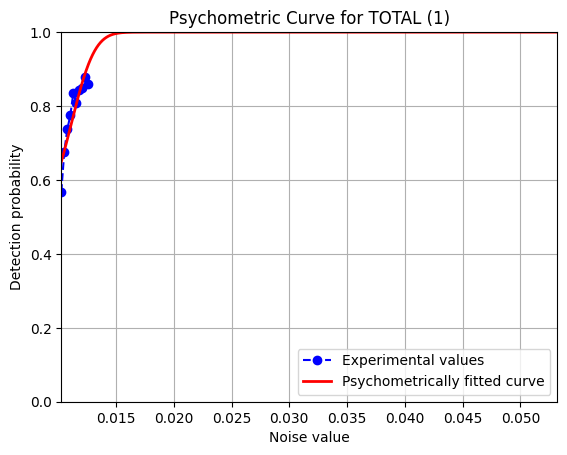

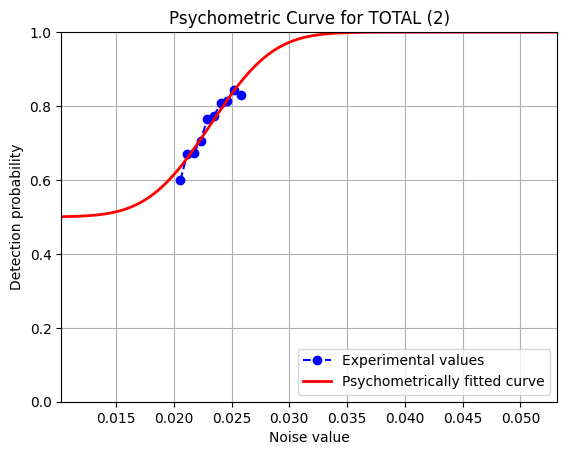

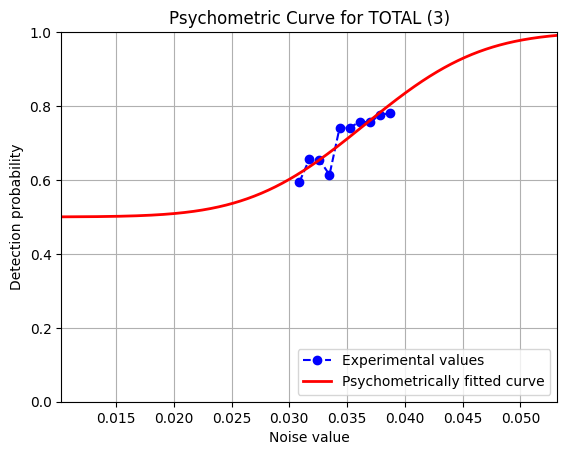

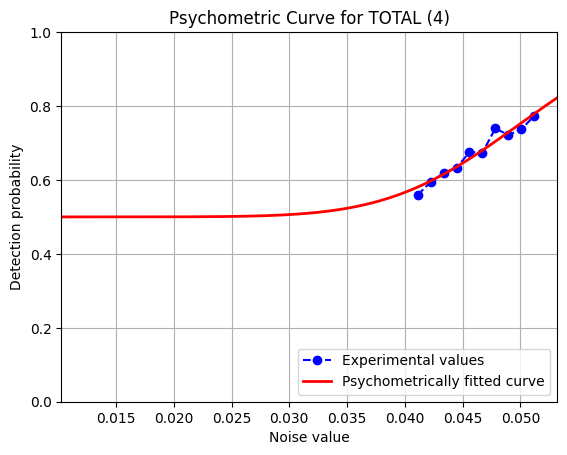

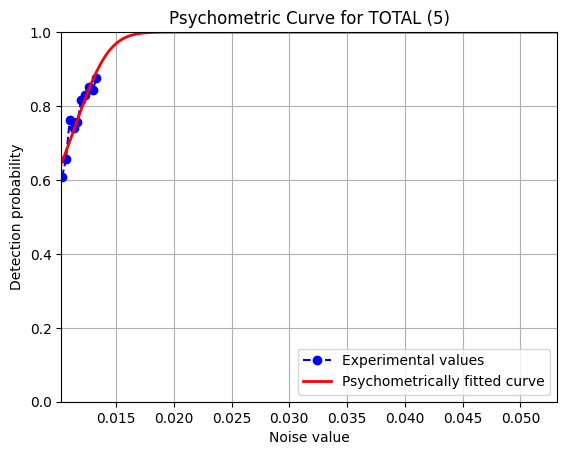

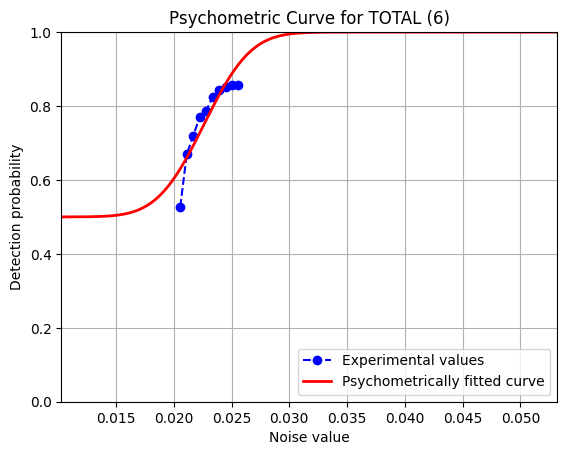

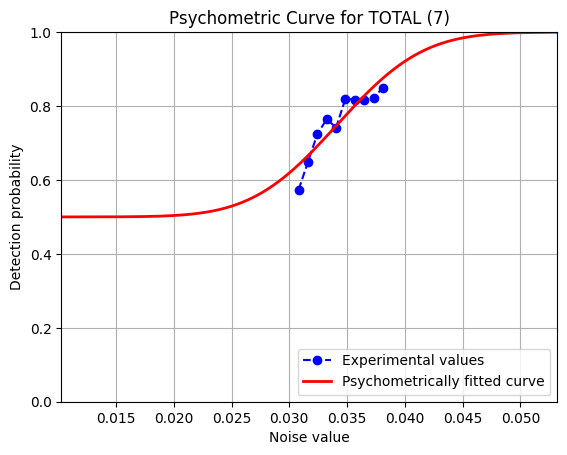

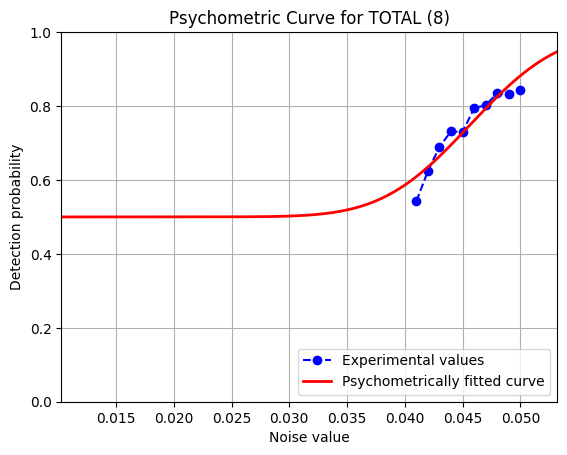

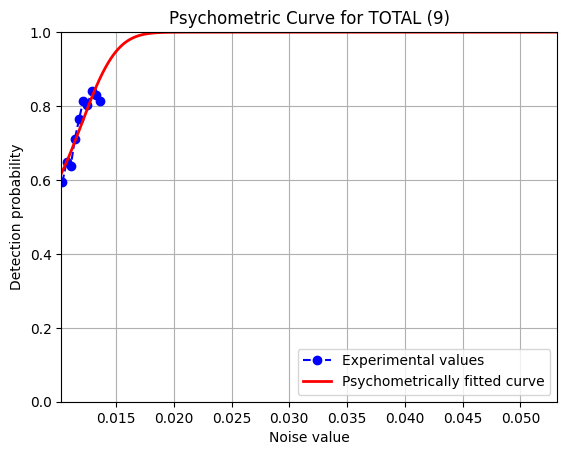

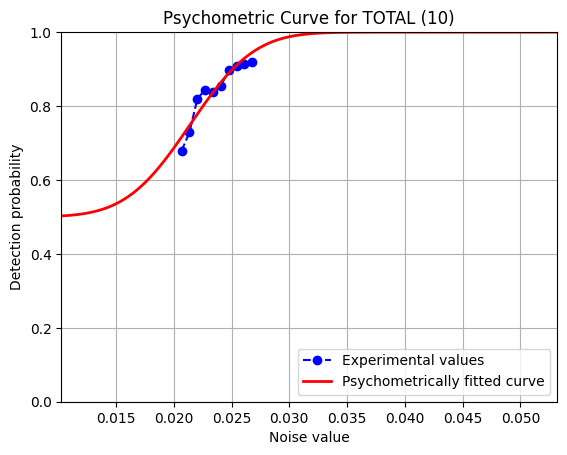

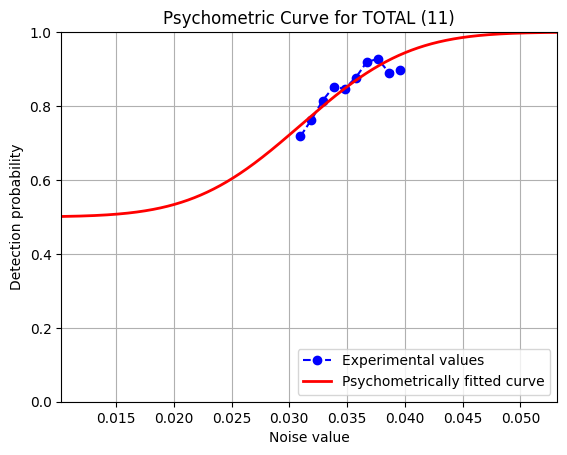

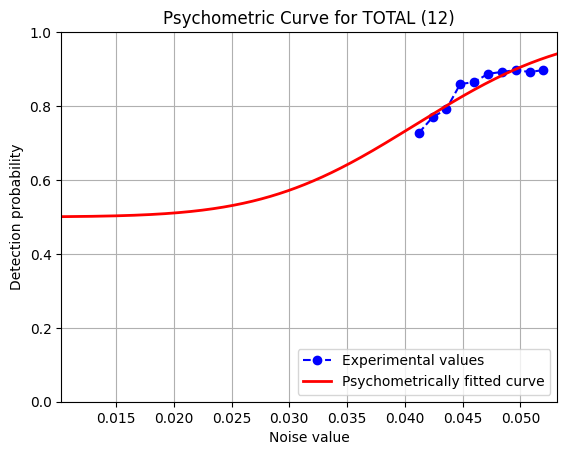

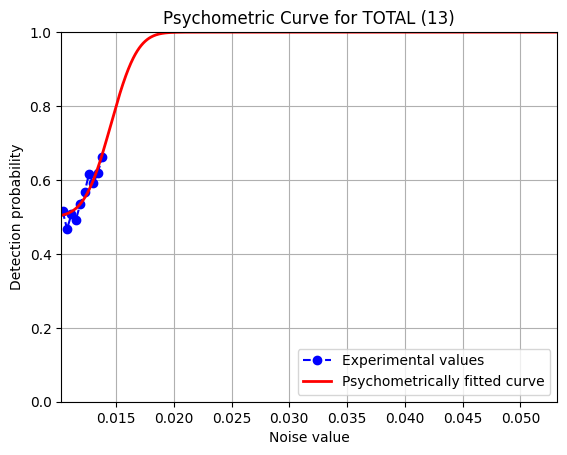

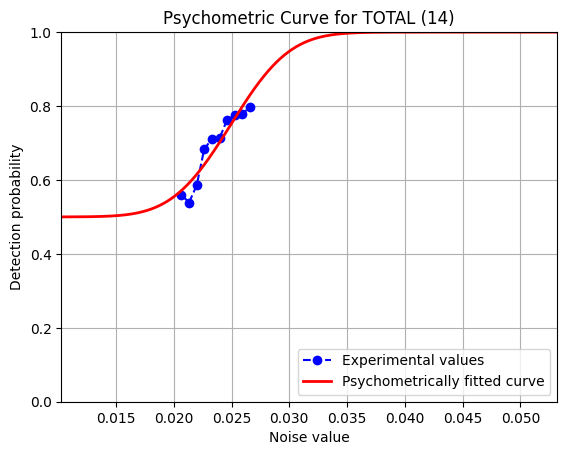

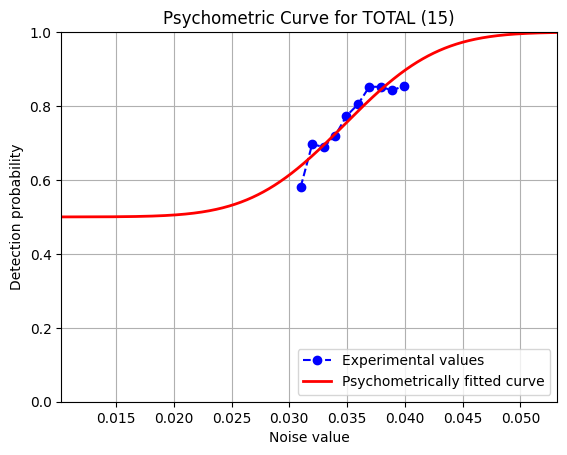

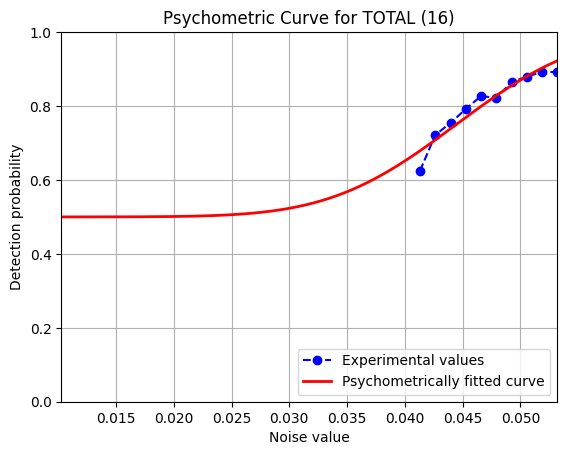

<Figure size 640x480 with 0 Axes>

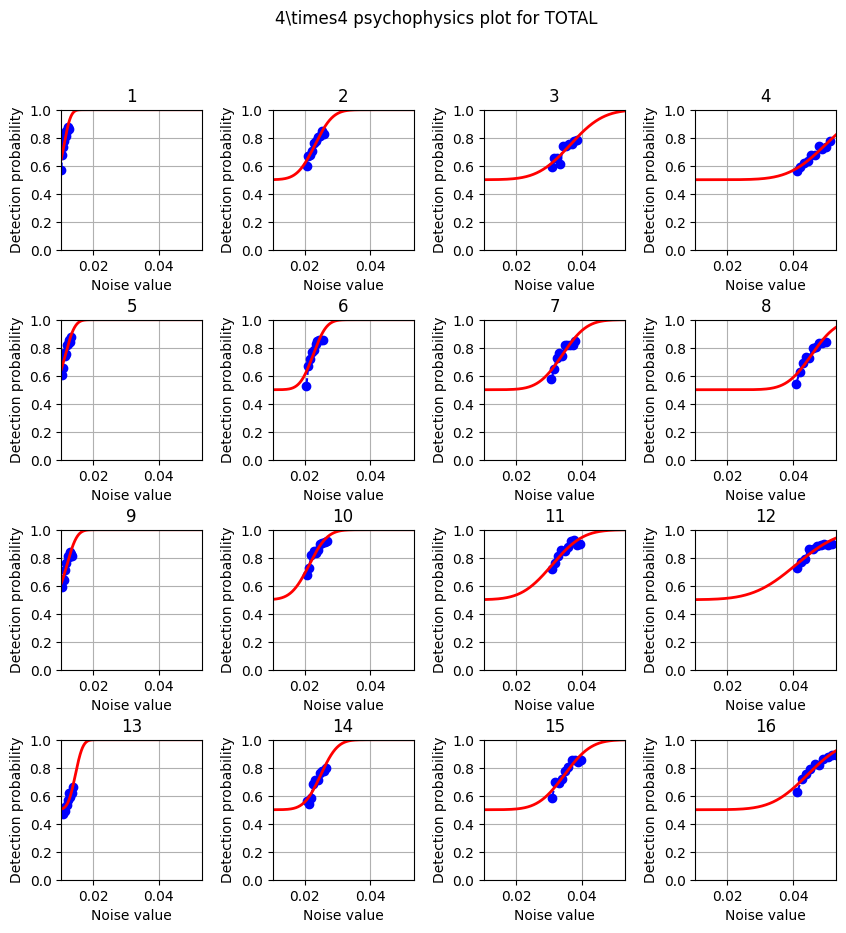

<Figure size 640x480 with 0 Axes>

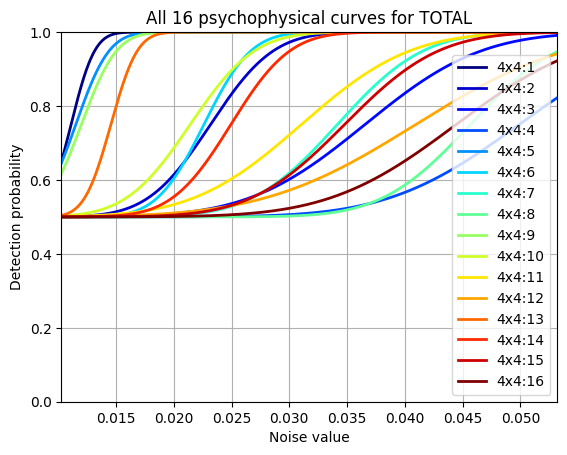

In [16]:
# TOTAL + UPV
mean_result_total = None
mean_std_total = []
for fichero in ficheros_total:
    data_file = fichero
    result = scipy.io.loadmat(data_file)
    result = np.array(result['Results'])
    if mean_result_total is None:
        mean_result_total = result
    else:
        mean_result_total = mean_result_total + result 
        # Suma de los resultados
        # Promediar la probabilidad y Promediar el tiempo
mean_result_total = mean_result_total/len(ficheros_total) # Media de los resultados para todos los ficheros de la TOTAL
    
# Individual plot
for i in range(LoopNumber):
    x = ruidos[i*numberObservations:(i+1)*numberObservations, 2]
    ruido_base = ruidos[i*numberObservations:(i+1)*numberObservations, 0][0]
    y = mean_result_total[i*numberObservations:(i+1)*numberObservations, 0]

    # Valores iniciales de la minimización
    X0 = [np.mean(x), 0.1*np.mean(x)]

    # parámetros para el ajuste
    params = {'x': x, 'y': y}

    # minimización
    ParamsOpt = minimize(normcdf2_minimizer, X0, args=params, method='Nelder-Mead').x

    # media y la desviación estándar de la distribución ajustada
    meanAndStdDistrib = [ParamsOpt[0], ParamsOpt[1]]

    # resultados en gráficos independientes
    plt.figure(i)
    plt.plot(x, y, 'o--b')
    plt.axis([min(x), max(x), 0, 1])
    x_curve = np.linspace(minX, maxX, num=1000)
    y_curve = normcdf2(x_curve, ParamsOpt[0], ParamsOpt[1])
    plt.plot(x_curve, y_curve, '-r', linewidth=2)
    plt.title('Psychometric Curve for TOTAL ('+ str(i+1)+")")
    plt.xlabel('Noise value')
    plt.ylabel('Detection probability')
    plt.legend(['Experimental values', 'Psychometrically fitted curve'], loc='lower right')
    plt.grid(True)
    plt.xlim([minX, maxX])
    plt.ylim([0, 1])

    # Guardar el gráfico y los datos en .npy
    plt.savefig(RESULTS_PATH_TOTAL+'/TOTAL-plot-' + str(i+1) + '.png')
    np.save(RESULTS_PATH_TOTAL+'/TOTAL-MeanStdDistribution-' + str(i+1) + '.npy', meanAndStdDistrib)
    mean_std_total.append((ruido_base, round(ParamsOpt[0], 6), round(ParamsOpt[1], 6)))

    plt.show()


# 4 times 4 psychophysics plot

plt.figure() 
figure = plt.figure(figsize=(numberObservations, numberObservations))
figure.subplots_adjust(hspace=0.5, wspace=0.5)

for i in range(LoopNumber):
    x = ruidos[i*numberObservations:(i+1)*numberObservations, 2]
    y = mean_result_total[i*numberObservations:(i+1)*numberObservations, 0]

    # Valores iniciales de la minimización
    X0 = [np.mean(x), 0.1*np.mean(x)]

    # Definir los parámetros para el ajuste
    params = {'x': x, 'y': y}

    # Realizar la minimización
    ParamsOpt = minimize(normcdf2_minimizer, X0, args=params, method='Nelder-Mead').x

    # Obtener la media y la desviación estándar de la distribución ajustada
    meanAndStdDistrib = [ParamsOpt[0], ParamsOpt[1]]

    ax = figure.add_subplot(4, 4, i+1)
    ax.plot(x, y, 'o--b')
    x_curve = np.linspace(minX, maxX, num=1000)
    y_curve = normcdf2(x_curve, ParamsOpt[0], ParamsOpt[1])
    ax.plot(x_curve, y_curve, '-r', linewidth=2)
    ax.grid(True)
    ax.set_xlim([minX, maxX])
    ax.set_ylim([0, 1])
    ax.set_title(str(i+1))
    ax.set_xlabel('Noise value')
    ax.set_ylabel('Detection probability')

figure.suptitle('4\\times4 psychophysics plot for TOTAL')
plt.savefig(RESULTS_PATH_TOTAL+'/TOTAL-MosaicWithEqualXAxes-' + str(i+1) + '.png')


# All 16 psychophysical curves

plt.figure() 
cc = plt.get_cmap('jet')(np.linspace(0, 1, 16))

fig, ax = plt.subplots()
for i in range(LoopNumber):
    x = ruidos[i*numberObservations:(i+1)*numberObservations, 2]
    y = mean_result_total[i*numberObservations:(i+1)*numberObservations, 0]

    # Valores iniciales de la minimización
    X0 = [np.mean(x), 0.1*np.mean(x)]

    # Definir los parámetros para el ajuste
    params = {'x': x, 'y': y}

    # Realizar la minimización
    ParamsOpt = minimize(normcdf2_minimizer, X0, args=params, method='Nelder-Mead').x

    # Obtener la media y la desviación estándar de la distribución ajustada
    meanAndStdDistrib = [ParamsOpt[0], ParamsOpt[1]]

    x_curve = np.linspace(minX, maxX, num=1000)
    y_curve = normcdf2(x_curve, ParamsOpt[0], ParamsOpt[1])
    ax.plot(x_curve, y_curve, linewidth=2, color=cc[i])
    ax.grid(True)
    ax.set_xlim([minX, maxX])
    ax.set_ylim([0, 1])
    ax.set_xlabel('Noise value')
    ax.set_ylabel('Detection probability')

ax.set_title('All 16 psychophysical curves for TOTAL')

Legend = []
for i in range(16):
    Legend.append('4x4:{}'.format(i+1))

ax.legend(Legend)

plt.savefig(RESULTS_PATH_TOTAL+'/TOTAL-AllPsychomPlots-' + str(i+1) + '.png')

In [17]:
data_total = [row for row in [mean_std_total[i:i+4] for i in range(0, 16, 4)]]
for row in data_total:
    print(row)
data_total

[(0.01, 0.011109, 0.001602), (0.02, 0.023179, 0.004269), (0.03, 0.036551, 0.0079), (0.04, 0.049895, 0.008882)]
[(0.01, 0.011517, 0.002267), (0.02, 0.022611, 0.003197), (0.03, 0.034158, 0.00583), (0.04, 0.045681, 0.006012)]
[(0.01, 0.011995, 0.002395), (0.02, 0.021421, 0.004373), (0.03, 0.031045, 0.007363), (0.04, 0.040944, 0.010311)]
[(0.01, 0.014554, 0.001798), (0.02, 0.024944, 0.00401), (0.03, 0.034783, 0.006386), (0.04, 0.044452, 0.008614)]


[[(0.01, 0.011109, 0.001602),
  (0.02, 0.023179, 0.004269),
  (0.03, 0.036551, 0.0079),
  (0.04, 0.049895, 0.008882)],
 [(0.01, 0.011517, 0.002267),
  (0.02, 0.022611, 0.003197),
  (0.03, 0.034158, 0.00583),
  (0.04, 0.045681, 0.006012)],
 [(0.01, 0.011995, 0.002395),
  (0.02, 0.021421, 0.004373),
  (0.03, 0.031045, 0.007363),
  (0.04, 0.040944, 0.010311)],
 [(0.01, 0.014554, 0.001798),
  (0.02, 0.024944, 0.00401),
  (0.03, 0.034783, 0.006386),
  (0.04, 0.044452, 0.008614)]]

Coeficiente de correlación (r): 0.9857192331356217


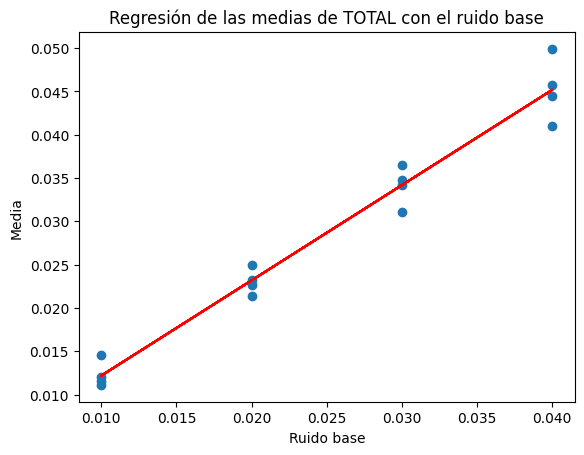

Coeficiente de correlación (r): -0.0326463894568797


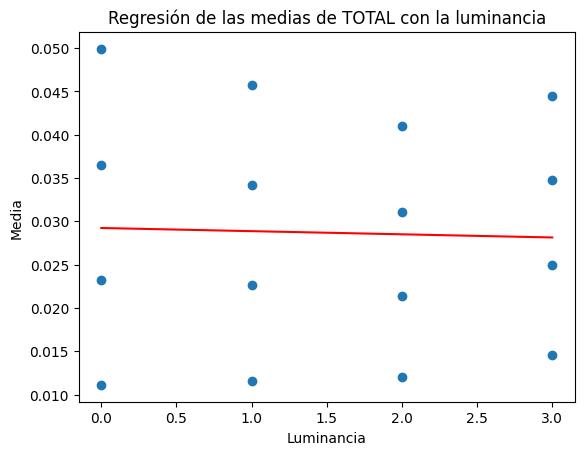

In [18]:
# Regresión de las medias y el ruido base

medias = np.array([i[1] for row in data_total for i in row])
ruido_base = np.array([i[0] for row in data_total for i in row])
luminancias = np.array([0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3])

slope, intercept, r_value, p_value, std_err = linregress(ruido_base, medias)
print("Coeficiente de correlación (r):", r_value)

plt.scatter(ruido_base, medias)
plt.plot(ruido_base, intercept + slope * ruido_base, 'r')
plt.title('Regresión de las medias de TOTAL con el ruido base')
plt.xlabel('Ruido base')
plt.ylabel('Media')
plt.show()

slope, intercept, r_value, p_value, std_err = linregress(luminancias, medias)
print("Coeficiente de correlación (r):", r_value)

plt.scatter(luminancias, medias)
plt.plot(luminancias, intercept + slope * luminancias, 'r')
plt.title('Regresión de las medias de TOTAL con la luminancia')
plt.xlabel('Luminancia')
plt.ylabel('Media')
plt.show()


Coeficiente de correlación (r): 0.4678748831441944


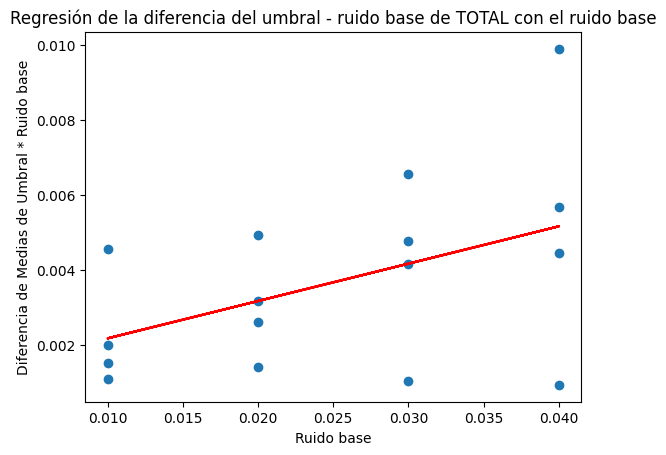

Coeficiente de correlación (r): -0.17133728089395311


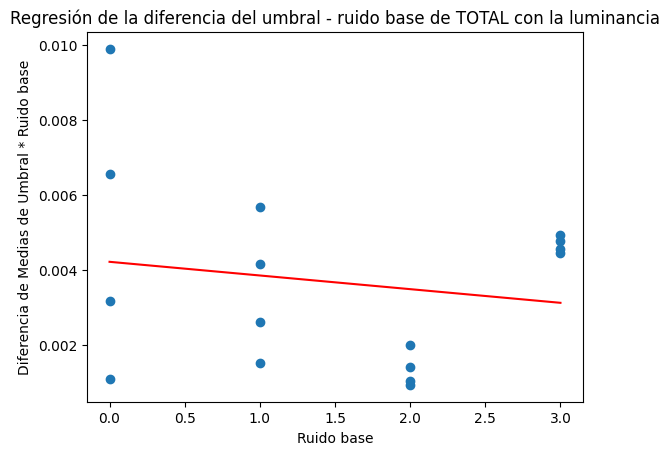

In [19]:
# Regresión de la diferencia del umbral - ruido base y el ruido base

dif_u_r = np.array([i[1]-i[0] for row in data_total for i in row])
ruido_base = np.array([i[0] for row in data_total for i in row])
luminancias = np.array([0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3])

slope, intercept, r_value, p_value, std_err = linregress(ruido_base, dif_u_r)
print("Coeficiente de correlación (r):", r_value)

plt.scatter(ruido_base, dif_u_r)
plt.plot(ruido_base, intercept + slope * ruido_base, 'r')
plt.title('Regresión de la diferencia del umbral - ruido base de TOTAL con el ruido base')
plt.xlabel('Ruido base')
plt.ylabel('Diferencia de Medias de Umbral * Ruido base')
plt.show()

slope, intercept, r_value, p_value, std_err = linregress(luminancias, dif_u_r)
print("Coeficiente de correlación (r):", r_value)

plt.scatter(luminancias, dif_u_r)
plt.plot(luminancias, intercept + slope * luminancias, 'r')
plt.title('Regresión de la diferencia del umbral - ruido base de TOTAL con la luminancia')
plt.xlabel('Ruido base')
plt.ylabel('Diferencia de Medias de Umbral * Ruido base')
plt.show()

[0.1109     0.15895    0.21836667 0.247375   0.1517     0.13055
 0.1386     0.142025   0.1995     0.07105    0.03483333 0.0236
 0.4554     0.2472     0.15943333 0.1113    ]
Coeficiente de correlación (r): -0.3498536081143103


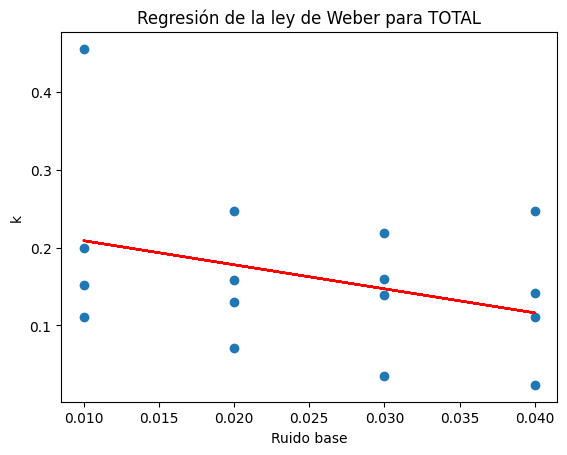

In [20]:
# Ley de Weber

# La diferencia mínima perceptible entre el ruido base y el ruido umbral en cada es cociente %
# (u-r)/r = k
k = np.array([((i[1]-i[0])/i[0]) for row in data_total for i in row])
print(k)
slope, intercept, r_value, p_value, std_err = linregress(ruido_base, k)
print("Coeficiente de correlación (r):", r_value)

plt.scatter(ruido_base, k)
plt.plot(ruido_base, intercept + slope * ruido_base, 'r')
plt.title('Regresión de la ley de Weber para TOTAL')
plt.xlabel('Ruido base')
plt.ylabel('k')
plt.show()

Coeficiente de correlación (r): 0.9330333661903568


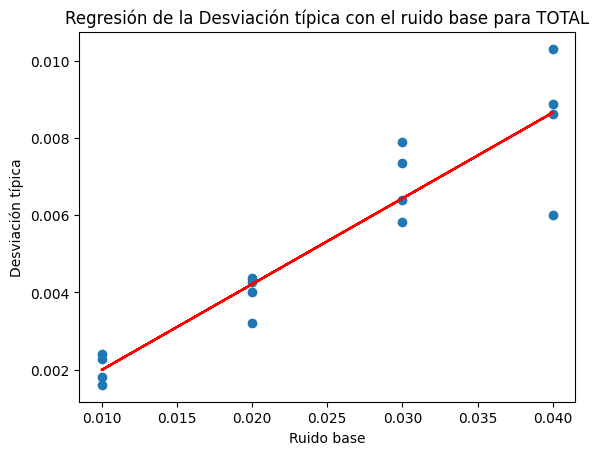

Coeficiente de correlación (r): 0.01680280783422865


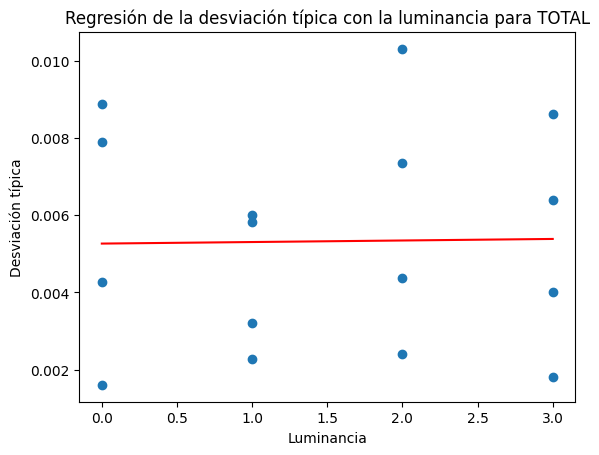

In [21]:
# Regresión de la desviación típica y el ruido base

std = np.array([i[2] for row in data_total for i in row])
ruido_base = np.array([i[0] for row in data_total for i in row])
luminancias = np.array([0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3])

slope, intercept, r_value, p_value, std_err = linregress(ruido_base, std)
print("Coeficiente de correlación (r):", r_value)

plt.scatter(ruido_base, std)
plt.plot(ruido_base, intercept + slope * ruido_base, 'r')
plt.title('Regresión de la Desviación típica con el ruido base para TOTAL')
plt.xlabel('Ruido base')
plt.ylabel('Desviación típica')
plt.show()

# Regresión de la desviación típica y la luminancia

slope, intercept, r_value, p_value, std_err = linregress(luminancias, std)
print("Coeficiente de correlación (r):", r_value)

plt.scatter(luminancias, std)
plt.plot(luminancias, intercept + slope * luminancias, 'r')
plt.title('Regresión de la desviación típica con la luminancia para TOTAL')
plt.xlabel('Luminancia')
plt.ylabel('Desviación típica')
plt.show()